# B404B Computational Finance

*Submission Date: June 26, 2022*

This notebook contains the code and explanations of **group 6** for the assessment in the course **B404B Computational Finance**.
The members are Jannis H., Jan Besler and Tim-Moritz B.

**Table of Contents**


1. [Setup and import Data](#setup)
2. [Definition of Signals](#I)
3. [Computation of Signals and resulting Stock Positions](#II)
4. [Resulting Statistics from the employed Strategy](#III)
5. [Graphs of Strategy](#IV)
6. [Additional Considerations](#V)

## Setup and import Data <a id="setup"></a>

First of all, we load the necessary packages, the price data (closing prices) and the respective price changes of the stocks under consideration and the S&P 500.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data

from scipy import stats
from matplotlib import gridspec
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# DOWNLOAD DATA

# only change the equity ticker strings if required
# don't change the variable name "tickers"
tickers = [ \
    'AAPL', # Apple
    'MSFT', # Microsoft
    'AMZN', # Amazon
    '^GSPC'] # S&P500 - Benchmark

# only change string values if required
# don't change the two variable names "start_date" and "end_date"
start_date = '2010-01-01'
end_date = '2021-12-31'

# download the time series of adj. close price
# for each of the tickers from Yahoo finance
price_data = {}

for ticker in tickers:
    price_data[ticker] = data.DataReader( \
        ticker, \
        'yahoo', \
        start = start_date, \
        end = end_date)['Adj Close']

# create dataframe with one row per day and adj. close price for each of the tickers
# and dataframe with price changes
df_prices = pd.concat([price_data[ticker].rename(ticker) for ticker in tickers], axis=1)
prev = df_prices.to_numpy()
prev = prev / np.insert(prev[:-1,:], 0, np.ones(prev.shape[1]), 0)
prev[0] = np.ones(prev.shape[1])
df_price_changes = df_prices.copy(deep=True)
df_price_changes[:] = prev

# print dataframes
print(df_prices)
print(df_price_changes)

TypeError: string indices must be integers, not 'str'

## Definition of Signals <a id="I"></a>

**Instructions**

*Do your research in a separate notebook and implement the final signals here. Remember that you may not use ready-to-use functions. When in doubt - code a function on your own. Example:.rolling().mean() is ready-to-use, that's why moving average is implemented below*

In the following, our three main trading signals are defined where each of them will consist of two sub-signals. To derive meaningful pairings, we paid attention to the fact that using multiple indicators from the same category (e.g., momentum) may result in multicollinearity. However, this should be avoided because it produces redundant results and does not offer much additional value. Hence, we will pair signals from different indicator categories to confirm each other and thereby, include different perspectives in the trading decisions to derive an accuracte and robust signal.


### Helper functions

In this section, helper functions are defined which are subsequently used in the definition of the signals. For in-depth explanations, please refer to the code comments.

First, `generate_signal()` defines how to construct one single signal based on two sub-signals. 
Specifically, we decided that either one of the two signals must indicate an entry signal to enter the position while both signals have to agree upon the exit. Thereby, we combine the strengths of both sub-signals and can derive a more stable and sophisticated trading signal.

In [ ]:
# function to generate an overall signal by combining the separate entry and exit signal points
def generate_signal(signal1: pd.Series, signal2: pd.Series) -> np.array:
    assert len(signal1) == len(signal2), "The two signals are not of the same length!"
    is_first = True
    output_lst = []

    #  both sub-signals are used for entry/exit
    for i in range(len(signal1)):

      # first entry signal
      if is_first and (signal1[i] == 1 or signal2[i] == 1):
          output_lst.append(1)
          is_first = False
          continue
      elif is_first:
          output_lst.append(0)
          continue

      # exit signal
      if output_lst[-1] == 1 and signal1[i] == 0 and signal2[i] == 0:
          output_lst.append(0)
          continue
      elif output_lst[-1] == 1:
          output_lst.append(1)
          continue

      # entry signal
      if output_lst[-1] == 0 and (signal1[i] == 1 or signal2[i] == 1):
          output_lst.append(1)
          continue
      elif output_lst[-1] == 0:
          output_lst.append(0)
          continue
          
    return np.array(output_lst)

Next, we define further useful functions for the signal constructions.

In [ ]:
# (Unbiased) Standard Deviation

def stddev(data):
    mean = float(sum(data) / len(data))
    var = float(sum([(x - mean) ** 2 for x in data]) / (len(data)-1) )
    return np.sqrt(var)

In [ ]:
# Pearson Correlation Coefficient

def pearsonCorr(x, y):
    assert len(x) == len(y), "The two data arrays are not of the same length!" # Assume len(x) == len(y)
    
    n = len(x)
    sum_x_sq = sum(xi*xi for xi in x)
    sum_y_sq = sum(yi*yi for yi in y)
    psum = sum(xi*yi for xi, yi in zip(x, y))
    num = psum - (sum(x) * sum(y)/n)
    den = np.sqrt((sum_x_sq - sum(x)**2 / n) * (sum_y_sq - sum(y)**2 / n))
    if den == 0: return 0
    return num / den

In [ ]:
# Bollinger Bands

def BollBand(data):
    # compute standard deviation and mean
    std = stddev(data)
    mean = sum(data) / len(data)
    # return upper & lower band
    return mean - std * 2, mean + std * 2

### Signal 1

In the first signal, the entry and exit are based on the (unadjusted) **MACD** and the **Ichimoku Cloud**. 

#### MACD

First, the **MACD** signal is a momentum indicator measuring the relationship between two (unadjusted) exponentially weighted moving averages and is calculated as follows.

$$
\text{MACD}^{\text{unadjusted}}_{t} = EWMA^{12}_{t}(\text{prices}) - EWMA^{26}_{t}(\text{prices})
$$
where
$$
EWMA^{n}_{t} = x_t * \alpha + (1 - \alpha) * EWMA^{n}_{t-1}
$$
$$
EWMA^{n}_{t_0} = \frac{1}{n} \sum_{t=t_0 - 9}^{t_0} x_{t}
$$
$$
\alpha =  \frac{2}{n + 1}
$$

Compared to the SMA, the EWMA allows to reduce the lag effect and puts more weight on more recent values.



Then, the associated signal line is defined as 
$$
s_t =  EMA^{9}_{t}(\text{MACD}^{\text{unadjusted}}_t)
$$

Finally, the MACD-signal is derived as
$$
    \text{MACD-Signal}_t= 
\begin{cases}
    1 & \text{if MACD}^{\text{unadjusted}}_{t} \gt s_t\\
    0 & \text{otherwise}
\end{cases}
$$

In [ ]:
def exponential_moving_average(prices, window_length):
    notNaN_idx = np.invert(np.isnan(prices))
    start_idx = np.where(notNaN_idx)[0][0]
    n = prices.shape[0]
    alpha = 2/(window_length + 1)
    results = np.empty(n)
    results.fill(np.nan) # initialize results array with NaN values
    results[start_idx+window_length-1] = prices[:window_length].sum() / window_length  # first value as Simple average over n periods
    for i in range(start_idx+window_length, n):
        results[i] = prices[i] * alpha + results[i-1]*(1-alpha) # compute exponential moving average
    return results

#### Ichimoku Cloud

The **Ichimoku Cloud** presents a comprehensive indicator which is composed of, in total, five smaller ones using different averages.

$$
\text{Conversion Line}_i = \frac{\max(\text{prices}_{i-8:i})+\min(\text{prices}_{i-8:i})}{2}
$$

$$\hspace{0pt}$$

$$
\text{Base Line}_i = \frac{\max(\text{prices}_{i-25:i})+\min(\text{prices}_{i-25:i})}{2}
$$

$$\hspace{0pt}$$

$$
\text{Leading Span A}_{i+26} = \frac{\text{Conversion Line}_i - \text{Base Line}_i}{2}
$$


$$\hspace{0pt}$$

$$
\text{Leading Span B}_{i+26} = \frac{\max(\text{prices}_{i-51:i})+\max(\text{prices}_{i-51:i})}{2}
$$

$$\hspace{0pt}$$

[For completion, but not used in our experiment: $\text{Lagging Span}_i = \text{prices}_{i-26} $]

$$\hspace{0pt}$$

As it can be seen, the Leading Spans A and B are shifted forward 26 periods.
These two spans constitute the boundaries of the so-called *Ichimoku Cloud*.

Thereby, this indicator yields insights about support/ resistance, trend direction and momentum. In general, several signals can be derived from the portrayed sub-indicators, while we will focus on the following considerations:

If the current price is above the Cloud and the Cloud is green (`Leading Span A > Leading Span B`), then a reinforced upward trend is observed. If in turn the current price is below Cloud and the Cloud is red (`Leading Span A < Leading Span B`), then a reinforced downward trend is observed. Hence, the Cloud is used as trend indicator providing a longer perspective on the price trend. Generally, a more voluminous cloud corresponds to a stronger trend. Thereby, it also acts as support and resistance boundaries and can filter between bullish and bearish market phases. Also, it is considered a noise zone if the price lies in the Cloud. Because the cloud is shifted forward 26 days, it further provides a glimpse of future support or resistance.

Finally, a buy-signal is triggered in case of an upward trend and an exit signal is derived in case of a downward trend.

In [ ]:
def ichimoku_cloud(prices):
    df_ic = pd.concat([prices], axis = 1)
    df_ic.rename(columns={ df_ic.columns[0]: "price" }, inplace = True)

    # initialize lists
    conversion_line, base_line, leading_a, leading_b, lagged = [], [], [], [], []
    
    for i in range(df_ic.shape[0]):
        
        # add NaN value for the cases, where not indicator can be derived
        if i < 25:
            conversion_line.append(np.nan)
            base_line.append(np.nan)
            leading_a.append(np.nan)
            leading_b.append(np.nan)
            lagged.append(np.nan)
        else:
            # calculate conversion line
            prices_window = prices[i-8:i+1]
            price_high = max(prices_window)
            price_low = min(prices_window)
            conversion_line.append((price_high+price_low) / 2)
   
            # calculate base line
            prices_window = prices[i-25:i+1]
            price_high = max(prices_window)
            price_low = min(prices_window)
            base_line.append((price_high+price_low) / 2)
            
            # calculate leading span a
            leading_a.append((conversion_line[-1] + base_line[-1])/2)
            
            # calculate leading span b
            if i < 51:
                leading_b.append(np.nan)
            else:
                prices_window = prices[i-51:i+1]
                price_high = max(prices_window)
                price_low = min(prices_window)
                leading_b.append((price_high+price_low) / 2)
            
            lagged.append(prices[i-26])

    # shift the leading spans 26 periods into the future            
    leading_a = [np.nan] * 26 + leading_a[:-26]
    leading_b = [np.nan] * 26 + leading_b[:-26]
            
    df_ic['conversion_line'] = conversion_line
    df_ic['base_line'] = base_line
    df_ic['leading_a'] = leading_a
    df_ic['leading_b'] = leading_b
    df_ic['lagged'] = lagged
    return df_ic

def generate_ic_signal(df_ic):
    is_first = True
    output_lst = []
    for i in range(df_ic.shape[0]):
        row = df_ic.iloc[i,:]
        
        # green cloud + price above the cloud -> first entry signal
        if is_first and (row['leading_a'] - row['leading_b'] > 0) and (row['price'] > max(row['leading_a'], row['leading_b'])):
            output_lst.append(1)
            is_first = False
            continue
        elif is_first:
            output_lst.append(0)
            continue
        
        # red cloud + price below the cloud -> exit signal
        if output_lst[-1] == 1 and (row['leading_a'] - row['leading_b'] < 0) and (row['price'] < min(row['leading_a'], row['leading_b'])):
            output_lst.append(0)
            continue
        elif output_lst[-1] == 1:
            output_lst.append(1)
            continue

        # green cloud + price above the cloud -> entry signal
        if output_lst[-1] == 0  and (row['leading_a'] - row['leading_b'] > 0) and (row['price'] > max(row['leading_a'], row['leading_b'])):
            output_lst.append(1)
            continue
        elif output_lst[-1] == 0:
            output_lst.append(0)
            continue
            
    return np.array(output_lst)

#### Construct the signal

Pairing the Ichimoku cloud with the MACD makes sense as the MACD can confirm the momentum in a certain trend direction. By combining one momentum indicator and one trend indicator, a more stable signal can be derived and used to counteract false exit signals.

Finally, the two signals are combined according to `generate_signal()` (see definition above in the section of helper functions) to constitute **Signal 1**.

In [ ]:
def signal_1(series):
    # Init
    signals = pd.DataFrame(index = series.index)
    signals['signal'] = 0.0
    signals['MACD_signal'] = 0.0
    signals['ichimoku_signal'] = 0.0
    
    # Compute exponential moving averages and derived MACD signal
    short_window = 12
    long_window = 26
    signals['short_ema'] = exponential_moving_average(series, short_window)
    signals['long_ema'] = exponential_moving_average(series, long_window)
    signals['MACD'] = signals['short_ema'] - signals['long_ema']
    signals['signal_line'] = exponential_moving_average(signals['MACD'], 9)
    signals['MACD_signal'][long_window:] = np.where(signals['MACD'][long_window:] > signals['signal_line'][long_window:], 1.0, 0.0)

    # Compute Ichimoku Cloud
    n_days = 52
    df_ic = ichimoku_cloud(series)
    signals['ichimoku_signal'][n_days+1:] = generate_ic_signal(df_ic[n_days+1:])

    # Compute signal
    signals['signal'][n_days+1:] = generate_signal(signals['MACD_signal'][n_days+1:], signals['ichimoku_signal'][n_days+1:])
    signals['position_change'] = signals['signal'].diff()
    signals.loc[series.index[0], 'position_change'] = 0
    return signals

### Signal 2

This signal is composed of the **Relative Strength Indicator (RSI)** and a **flashing indicator**.

#### Relative Strength Indicator (RSI)

The **RSI** is a momentum indicator which relates the recent average gain to the recent average loss of the price oscillations over a window size of 14 days. Thereby, it tries to assess whether a security is overbougt or oversold.

First, the average gain and average loss over a rolling window is calculated as follows.

$$
\text{Average gain}_t = \frac{1}{14} \sum_{i=t-13}^{t} \text{max}(0,x_{i} - x_{i-1})
$$

$$
\text{Average loss}_t = \frac{1}{14} \sum_{i=t-13}^{t} |\text{min}(0,x_{i} - x_{i-1})|
$$

Second, these values are used to compute the corresponding RSI values.

$$
\text{RSI}_{t_0} = 100 - \left[ \frac{100}{1+\frac{\text{Average gain}_{t_{0}}}{\text{Average loss}_{t_{0}}}} \right]
$$

$$
\text{RSI}_t = 100 - \left[ \frac{100}{1+\frac{\frac{1}{14}\left [(\text{Average gain}_{t-1} * 13) + \text{Gain}_t \right]}{\frac{1}{14}\left [(\text{Average loss}_{t-1} * 13) + \text{Loss}_t \right]}} \right]
$$


Finally, the a RSI value below 30 is usually taken as a buy signal (oversold market) and conversely, a RSI value above 70 is used as a sell signal (overbought market). Hence, the trading signals are derived as

$$
    \text{Buy-Signal}_t= 
\begin{cases}
    1 & \text{if RSI}_{t} \lt 30\\
    0 & \text{otherwise}
\end{cases}
$$

$$
    \text{Sell-Signal}_t= 
\begin{cases}
    1 & \text{if RSI}_{t} \gt 70\\
    0 & \text{otherwise}
\end{cases}
$$

Ultimately, these will be combined using `generate_rsi_signal()`.

In [ ]:
# Relative Strength Index

def relative_strength_index(prices, window_length = 14):
    df_rsi = pd.concat([prices], axis = 1)
    differences = pd.Series(np.insert((prices[1:].to_numpy() - prices[:-1].to_numpy()), 0, np.nan, axis=0), index = prices.index)

    # compute gains and losses of prices
    df_rsi['gain'] = differences.apply(lambda x: x if x > 0 else 0)    
    df_rsi['loss'] = differences.apply(lambda x: np.abs(x) if x < 0 else 0) 

    window_idx = window_length-1
    avg_gains = []
    avg_losses = []
    for i in range(df_rsi.shape[0]):
        # add NaN values where RSI cannot be derived
        if i < window_idx:
            avg_gains.append(np.nan)
            avg_losses.append(np.nan)

        # calculate first average gain and loss
        elif i == window_idx:
            avg_gains.append(sum(df_rsi['gain'][i-window_length+1:i+1])/len(df_rsi['gain'][i-window_length+1:i+1]))
            avg_losses.append(sum(df_rsi['loss'][i-window_length+1:i+1])/len(df_rsi['loss'][i-window_length+1:i+1]))

        # calculate average gain and loss
        else:
            avg_gains.append((avg_gains[-1] * (window_length-1) + df_rsi['gain'][i]) / window_length)
            avg_losses.append((avg_losses[-1] * (window_length-1) + df_rsi['loss'][i]) / window_length)

    # derive RSI     
    df_rsi['avg_gains'] = avg_gains
    df_rsi['avg_losses'] = avg_losses
    df_rsi['rs'] = df_rsi['avg_gains'] / df_rsi['avg_losses']
    df_rsi['rsi'] = (100 - (100 / (1 + df_rsi['rs'])))
    return df_rsi['rsi']


# generate the RSI signal based on the provided borders according to the procedure described above
def generate_rsi_signal(rsi, border_buy, border_sell):
    is_first = True
    output_lst = []
    for i in range(len(rsi)):
        if is_first and rsi[i] < border_buy:
            output_lst.append(1)
            is_first = False
            continue
        elif is_first:
            output_lst.append(0)
            continue
            
        if output_lst[-1] == 1 and rsi[i] > border_sell:
            output_lst.append(0)
            continue
        elif output_lst[-1] == 1:
            output_lst.append(1)
            continue
        
        if output_lst[-1] == 0 and rsi[i] < border_buy:
            output_lst.append(1)
            continue
        elif output_lst[-1] == 0:
            output_lst.append(0)
            continue
            
    return np.array(output_lst)   

#### Flashing Indicator

The **Flashing Indicator** is composed of the Rate of Change (ROC) of a security with volatility bands around it and a parallel (exogenous) calculation of the Autocorrelation of the price.


$$
ROC_t = \frac{\text{prices}_t - \text{prices}_{t-1}}{\text{prices}_{t-1}} * 100
$$

Next, Bollinger Bands around ROC are calculated using a window size of 10 to include two trading weeks.

$$
\text{Upper Bollinger Band}_t = \left( \frac{1}{n} \sum_{i=t_0 - 9}^{t_0} ROC_i \right) - k* \sigma(ROC_{t-9:t})
$$

$$
\text{Lower Bollinger Band}_t = \left( \frac{1}{n} \sum_{i=t_0 - 9}^{t_0} ROC_i \right) + k* \sigma(ROC_{t-9:t})
$$

Here, we will use the typical value of $k = 2$.

Autocorrelation is the correlation of a time series with its own lagged values. Next, we will include the autocorrelation of the prices with one lag.


$$
\rho_t = \frac{\sum_{i=t-9}^{t} \text{prices}_i*\text{prices}_{i-1} - \frac{1}{10} \left(\sum_{i=t-9}^{t} \text{prices}_i \right) \left(\sum_{i=t-10}^{t-1} \text{prices}_i \right)}{\sqrt{\sum_{i=t-9}^{t} \text{prices}_i^2 - \frac{1}{10} \left(\sum_{i=t-9}^{t} \text{prices}_i \right) ^2} \sqrt{\sum_{i=t-10}^{t-1} \text{prices}_i^2 - \frac{1}{10} \left(\sum_{i=t-10}^{t-1} \text{prices}_i \right) ^2}}
$$

Based on those measures, we can derive the respective buy and sell signals as follows.

$$
    \text{Buy-Signal}_t= 
\begin{cases}
    1 & \text{if (}\rho_{t} \gt 0.9) \text{ and } (ROC_t > \text{Upper Bollinger Band}_t) \\
    0 & \text{otherwise}
\end{cases}
$$

$$
    \text{Sell-Signal}_t= 
\begin{cases}
    1 & \text{if (}\rho_{t} \gt 0.9) \text{ and } (ROC_t < \text{Lower Bollinger Band}_t) \\    
    0 & \text{otherwise}
\end{cases}
$$

With the Bollinger Bands on the ROC of a stock, an indicator for volatility is created. When the moving average of the ROC touches the upper Bollinger Band, this indicates a rapid and sharp price change which directly influences the volatility.

In combination with a high autocorrelation of the stock prices, this amplifies a high volatility increase, since the price are not diverging to much during a short time horizon while still having a high ROC marking over a longer period of time. Under the mean reversion assumption a high volatility increase signals a change in trend.

Hence, for an increase in volatility with the ROC being above the upper band, a buy signal is generated. And vice versa a sell signal is produced if the lower bands are touched while the autocorrelation is high.

In [ ]:
# Flashing indicator

def flashingIndicator(prices, windowSize):
  
    df = pd.concat([prices], axis = 1)
    ROC, Boll_up, Boll_down, acs = [], [], [], []

    # Calculate the Rate of Change for given window size
    for i in range(len(prices)):
        if i < windowSize-1:
            ROC.append(np.nan)
        else:
            ROC.append((prices[i] - prices[i - windowSize]) / prices[i - windowSize] * 100)

        if i < windowSize*2 -1:
            Boll_up.append(np.nan)
            Boll_down.append(np.nan)
            acs.append(np.nan)
            continue

        # apply Bollinger Bands on the Rate of Change
        band_down, band_up = BollBand(ROC[i-windowSize*2+1:i+1])
        Boll_up.append(band_up)
        Boll_down.append(band_down)

        # define autocorrelation part with lag = 1
        acs.append(pearsonCorr(prices[i - windowSize :i + 1],
                               prices[i - windowSize - 1 : i]))

    df['ROC'] = ROC
    df['Bollinger Up'] = Boll_up
    df['Bollinger Down'] = Boll_down
    df['Autocorrelation'] = acs

    return df


def generate_fi_signal(df_fi):
    is_first = True
    output_lst = []
    for i in range(df_fi.shape[0]):
        row = df_fi.iloc[i,:]

        vol = row['Autocorrelation'] > 0.9
        
        # high autocorrelation + ROC above the Upper Band -> first entry signal
        if is_first and vol and (row['ROC'] > row['Bollinger Up']):
            output_lst.append(1)
            is_first = False
            continue
        elif is_first:
            output_lst.append(0)
            continue
        
        # high autocorrelation + ROC below the Lower Band -> exit signal
        if output_lst[-1] == 1 and vol and (row['ROC'] < row['Bollinger Down']):
            output_lst.append(0)
            continue
        elif output_lst[-1] == 1:
            output_lst.append(1)
            continue

        # high autocorrelation + ROC above the Upper Band -> entry signal
        if output_lst[-1] == 0 and vol and (row['ROC'] > row['Bollinger Up']):
            output_lst.append(1)
            continue
        elif output_lst[-1] == 0:
            output_lst.append(0)
            continue
            
    return np.array(output_lst)

#### Construction of signal

Again, these two signals belong to different types of indicators (RSI: momentum oscillator, Flashing indicator: volatility) and therefore, using them in conjunction enables us to assess a more complete technical picture about the stock development. 

Eventually, the buy and sell signals just described are computed and combined using `generate_signal()` to contitute **Signal 2**.

In [ ]:
def signal_2(series):
    # Init
    signals = pd.DataFrame(index = series.index)
    signals['signal'] = 0.0
    signals['exit_signal'] = 0.0

    # Compute RSI
    window = 14
    signals['relative_strength_index'] = relative_strength_index(series)
    signals['relative_strength_index_signal'] = generate_rsi_signal(signals['relative_strength_index'], 30, 70)

    # Compute Flashing indicator
    windowSize = 10
    df_fi = flashingIndicator(series, windowSize)
    signals['flashing_indicator_signal'] = generate_fi_signal(df_fi)
    
    # Compute signal
    signals['signal'][window:] = generate_signal(signals['relative_strength_index_signal'][window:], signals['flashing_indicator_signal'][window:])
    
    signals['position_change'] = signals['signal'].diff()
    signals.loc[series.index[0], 'position_change'] = 0
    return signals

### Signal 3

In this signal, both the entry and exit are based again on two sub-signals, namely a **Trading Breakout** and the **Dynamic Momentum Index** which are defined in the following.

#### Trading Breakout

Generally, a **trading breakout indicator** tries to identify the optimal market entry by spotting a breakout from the current price patterns which might be followed by increasing volatility in either direction to infer its future development. Hence, one wants to take a position within a trend's early stages.

Generally, financial markets are subject to trand phases and consolidation phases. In our application, we define a bullish breakout as a positive spike in the stock price after a consolidation phase of prices. A bearish breakout is defined accordingly by spotting a negative spike. Mathematically, this Boolean consolidation indicator is defined as follows.

(Usually, it could also be computed by comparing the daily high and low prices of stocks and/or consider trading volume, however, this is not applicable to the setting at hand)

$$
\text{consolidation}(p)_t = \text{min(prices}_{t-15:t}) \gt \text{max(prices}_{t-15:t})*\left(1-\frac{p}{100} \right)
$$

In our setting, we choose $p = 2.5$.

Using this Boolean indicator, the buy and sell signal are defined as follows.

$$
    \text{Buy-Signal}_t= 
\begin{cases}
    1 & \text{if (consolidation}_t = \text{True) and (price}_t \gt \text{max(prices)}_{t:t-15})\\
    0 & \text{otherwise}
\end{cases}
$$

$$
    \text{Sell-Signal}_t= 
\begin{cases}
    1 & \text{if (consolidation}_t = \text{True) and (price}_t \lt \text{min(prices)}_{t:t-15})\\
    0 & \text{otherwise}
\end{cases}
$$

Based on those, the final signal can be derived my entering/leaving the stock position accordingly (see `generate_breaking_out_signal()`).

In [ ]:
# Trading Breakout

# compute Boolean consolidation indicator
def consolidation(recent_prices, percentage=2.5):    
    max_close = max(recent_prices)
    min_close = min(recent_prices)

    threshold = 1 - (percentage / 100)
    if min_close > (max_close * threshold):
        return True        
    return False

# generate the Trading Breakout signal according to the above discription
def generate_breaking_out_signal(prices, recent_n = 15, percentage = 2.5):
    is_first = True
    output_lst = []
    for i in range(len(prices)):
        if i < recent_n:
            output_lst.append(np.nan)
            continue
        
        last_close = prices[i]

        # consolidation + positive spike -> first entry signal        
        if is_first and consolidation(prices[i-recent_n:i], percentage=percentage) and (last_close > max(prices[i - recent_n:i])):
            output_lst.append(1)
            is_first = False
            continue
        elif is_first:
            output_lst.append(0)
            continue

        # consolidation + negative spike -> exit signal        
        if output_lst[-1] == 1 and consolidation(prices[i-recent_n:i], percentage=percentage) and (last_close < min(prices[i - recent_n:i])):
            output_lst.append(0)
            continue
        elif output_lst[-1] == 1:
            output_lst.append(1)
            continue

        # consolidation + positive spike -> entry signal               
        if output_lst[-1] == 0 and consolidation(prices[i-recent_n:i], percentage=percentage) and (last_close > max(prices[i - recent_n:i])):
            output_lst.append(1)
            continue
        elif output_lst[-1] == 0:
            output_lst.append(0)
            continue
            
    return np.array(output_lst)

#### Dynamic Momentum Index

As the second sub-signal, we choose the **Dynamic Momentum Index** which presents an extension to the previously discussed *Relative Strength Indicator*. While the general idea and calculations remain the same, the window size is now a variable factor $d_t$ rather than being fixed to $d = 14$. Thereby, the number of days can be adjusted according to market volatility. Intuitively, as volatility decreases, additional data is used for a better assessment of earlier market developments (and vice versa). As this indicator is more sensitive, it might find earlier entry and exit signals than the RSI, but might also be more prone to false signals.

$$
d_t^{\text{raw}} = \frac{\sigma(prices_{t-5:t})}{\frac{1}{10} \sum_{i=t-10}^{t}\sigma(prices_{i-5:i})}
$$

$$
d_t = \text{max}\left(30, \text{min}\left(5, {\text{int}\left(\frac{14}{d_t^{\text{raw}}}\right)}\right)\right)
$$

The remaining calculations stay the same.


$$
\text{Average gain}_i = \frac{1}{d} \sum_{t=i}^{i+d} \text{max}(0,x_{t} - x_{t-1})
$$

$$
\text{Average loss}_i = \frac{1}{d} \sum_{t=i}^{i+d} |\text{min}(0,x_{t} - x_{t-1})|
$$

Using the average gain and loss, the DMI index value is derived.

$$
\text{DMI}_{t_0} = 100 - \left[ \frac{100}{1+\frac{\text{Average gain}_{t_{0}}}{\text{Average loss}_{t_{0}}}} \right]
$$

$$
\text{DMI}_t = 100 - \left[ \frac{100}{1+\frac{\frac{1}{d}\left [(\text{Average gain}_{t-1} * (d-1)) + \text{Gain}_t \right]}{\frac{1}{d}\left [(\text{Average loss}_{t-1} * (d-1)) + \text{Loss}_t \right]}} \right]
$$


Using the DMI, the entry and exit signals are derived as follows with the usually taken boundary values 30 and 70.

$$
    \text{Buy-Signal}_t= 
\begin{cases}
    1 & \text{if DMI}_t \lt 30 \\
    0 & \text{otherwise}
\end{cases}
$$

$$
    \text{Sell-Signal}_t= 
\begin{cases}
    1 & \text{if DMI}_t \gt 70 \\
    0 & \text{otherwise}
\end{cases}
$$

Based on those, the final signal can be derived my entering/leaving the stock position accordingly (re-using `generate_rsi_signal()`).

In [ ]:
# Dynamic Momentum Index

# calculate window that is used in period t
def window_employed(prices, i):
    std = stddev(prices[i-4:i+1])
    stds_10 = [stddev(prices[j-4:j+1]) for j in range(i-10,i)]
    ma_stds10 = sum(stds_10) / len(stds_10)
    d_raw = std / ma_stds10
    d = int(14 / d_raw)
    d = min(30, max(5, d))
    return d

def dynamic_momentum_index(prices, n_days):
    df_dmi = pd.concat([prices], axis = 1)
    differences = pd.Series(np.insert((prices[1:].to_numpy() - prices[:-1].to_numpy()), 0, np.nan, axis=0), index = prices.index)

    # calculate gains and losses
    df_dmi['gain'] = differences.apply(lambda x: x if x > 0 else 0)    
    df_dmi['loss'] = differences.apply(lambda x: np.abs(x) if x < 0 else 0) 

    avg_gains = []
    avg_losses = []
    first_calc = True
    for i in range(df_dmi.shape[0]):
        if i < n_days+1:
            avg_gains.append(np.nan)
            avg_losses.append(np.nan)
        else:
            window_length = window_employed(prices, i)
            if first_calc == True:
                avg_gains.append(sum(df_dmi['gain'][i-window_length+1:i+1])/len(df_dmi['gain'][i-window_length+1:i+1]))
                avg_losses.append(sum(df_dmi['loss'][i-window_length+1:i+1])/len(df_dmi['loss'][i-window_length+1:i+1]))
                first_calc = False
            else:
                avg_gains.append((avg_gains[-1] * (window_length-1) + df_dmi['gain'][i]) / window_length)
                avg_losses.append((avg_losses[-1] * (window_length-1) + df_dmi['loss'][i]) / window_length)

            
    # compute DMI
    df_dmi['avg_gains'] = avg_gains
    df_dmi['avg_losses'] = avg_losses
    df_dmi['dm'] = df_dmi['avg_gains'] / df_dmi['avg_losses']
    df_dmi['dmi'] = (100 - (100 / (1 + df_dmi['dm'])))
    
    return df_dmi['dmi']

#### Construction of the signal

As the identification of breakouts may fail and the DMI also has its limitations (for example, still an inherent lag), it makes sense to combine both indicators to construct one holistic signal. Both sub-signals are again combined using `generate_signal()` to obtain **Signal 3**.

In [ ]:
pd.options.mode.chained_assignment = None 

def signal_3(series):
    # Init
    signals = pd.DataFrame(index = series.index)
    signals['signal'] = 0.0
    signals['dmi_signal'] = 0.0
    
    # Compute Trading Bbreakouts
    recent_n = 8
    signals['breakout'] = generate_breaking_out_signal(series, recent_n)

    # Compute Dynamic Momentum Index
    n_days = 14
    signals['dynamic_momentum_index'] = dynamic_momentum_index(series, n_days)
    signals['dmi_signal'][n_days+1:] = generate_rsi_signal(signals['dynamic_momentum_index'][n_days+1:], 30, 70) # can re-use function from RSI signal

    # Compute signal
    signals['signal'][max(recent_n, n_days):] = generate_signal(signals['breakout'][max(recent_n, n_days):], signals['dmi_signal'][max(recent_n, n_days):])
    signals['position_change'] = signals['signal'].diff()
    signals.loc[series.index[0], 'position_change'] = 0
    return signals

## Computation of Signals and resulting Stock Positions <a id="II"></a>

First, we need to decide on the pairing of stock and signal for the subsequent backtesting of our trading strategy. To do so, we take the price developments of the three stocks over the period at hand into account.

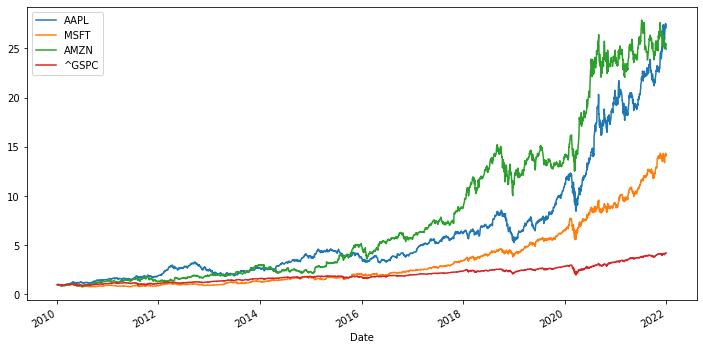

In [ ]:
for stock in tickers:
    (df_prices[stock] / df_prices[stock][0]).plot(label = stock, figsize = (12,6), legend = True)

Based on the graph, it can be seen that that **AMZN** might exhibit more periods of consolidation with subsequent breakouts. Therefore, we choose to pair it with Signal 3.

Next, it might suitable to use Signal 2 for **AAPL** as this stock is more volatile than **MSFT** and hence, the volatility-based flashing indicator might prove useful.

Last, **MSFT** presents the most stable stock development out of the three stocks and therefore, we will pair it with Signal 1.

Based on this allocation, the pairs of stock and signal are used for trading and combined to derive our portfolio position. As these trading operations remain unchanged compared to the initial base notebook, no further descriptions are necessary.

In [ ]:
# Compute signals
signals = {}

signals['MSFT'] = signal_1(df_prices['MSFT'])
signals['AAPL'] = signal_2(df_prices['AAPL'])
signals['AMZN'] = signal_3(df_prices['AMZN'])
df_position_open = pd.concat([
    signals[tickers[0]]['signal'].rename(tickers[0]),
    signals[tickers[1]]['signal'].rename(tickers[1]),
    signals[tickers[2]]['signal'].rename(tickers[2])], axis = 1)
df_position_changes = pd.concat([
    signals[tickers[0]]['position_change'].rename(tickers[0]),
    signals[tickers[1]]['position_change'].rename(tickers[1]),
    signals[tickers[2]]['position_change'].rename(tickers[2])], axis = 1)

In [ ]:
# ALLOCATE CAPITAL AND COMPUTE RESULTING POSITIONS
initial_cash = 1.0
capital_fraction_per_trade = 0.05

# DO NOT MODIFY THIS CELL BELOW THIS LINE
position = []

def open_trades(position, position_change):
    vec = np.maximum([position_change[ticker] for ticker in tickers[:-1]], [0])
    vec = position[-1] * (1 - np.power((1 - capital_fraction_per_trade), np.sum(vec))) * vec / (1 if (np.nansum(vec) == 0.0) else np.nansum(vec))
    return np.append(vec + position[:-1], position[-1] - np.sum(vec))

def hold_trades(position, price_change):
    return np.concatenate((position[:-1] * price_change[:-1], [position[-1]]))

def close_trades(position, position_change):
    vec = np.concatenate((np.array([position_change[ticker] < 0.0 for ticker in tickers[:-1]]), [False]))
    position[-1] = position[-1] + np.sum(position[vec])
    position[vec] = 0.0
    return position
    
is_first = True
for idx, position_change in df_position_changes.iterrows():
    if is_first:
        position.append(open_trades(np.concatenate((np.zeros(len(df_position_changes.columns)), [initial_cash])), position_change))
        is_first = False
    else:
        hlpr_pos = hold_trades(position[-1], df_price_changes.loc[[idx]].to_numpy()[0])
        hlpr_pos = close_trades(hlpr_pos, position_change)
        position.append(open_trades(hlpr_pos, position_change))

df_position = pd.DataFrame(position, index = df_prices.index, columns = tickers[:-1] + ['cash'])

In addition to deriving the portfolio position based on our new three signals (**df_position**), we also compute the portfolio position resulting from the three base signals given in initial notebook (**df_position_old**). Thereby, both portfolio positions can be compared at a later stage.

In [ ]:
def moving_average(prices, window_length):
    return np.convolve(prices, np.ones(window_length)/window_length, mode='same')

### SIGNAL 1
def signal_1_old(series):
    # Init
    signals = pd.DataFrame(index = series.index)
    signals['signal'] = 0.0
    
    # Compute simple moving average
    short_window = 250
    long_window = 500
    signals['short_ma'] = moving_average(series, short_window)
    signals['long_ma'] = moving_average(series, long_window)

    # Compute signals
    signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:]  
                                                > signals['long_ma'][short_window:] , 1.0, 0.0)   
    signals['position_change'] = signals['signal'].diff()
    signals.loc[series.index[0], 'position_change'] = 0
    return signals

### SIGNAL 2
def signal_2_old(series):
    # Init
    signals = pd.DataFrame(index = series.index)
    signals['signal'] = 0.0
    
    # Compute simple moving average
    short_window = 125
    long_window = 250
    signals['short_ma'] = moving_average(series, short_window)
    signals['long_ma'] = moving_average(series, long_window)

    # Compute signals
    signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:] 
                                                > signals['long_ma'][short_window:], 1.0, 0.0)   
    signals['position_change'] = signals['signal'].diff()
    signals.loc[series.index[0], 'position_change'] = 0
    return signals

### SIGNAL 3
def signal_3_old(series):
    # Init
    signals = pd.DataFrame(index = series.index)
    signals['signal'] = 0.0
    
    # Compute simple moving average
    short_window = 60
    long_window = 120
    signals['short_ma'] = moving_average(series, short_window)
    signals['long_ma'] = moving_average(series, long_window)

    # Compute signals
    signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:] 
                                                > signals['long_ma'][short_window:], 1.0, 0.0)   
    signals['position_change'] = signals['signal'].diff()
    signals.loc[series.index[0], 'position_change'] = 0
    return signals

# Compute signals
signals_old = {}
signals_old[tickers[0]] = signal_1_old(df_prices[tickers[0]])
signals_old[tickers[1]] = signal_2_old(df_prices[tickers[1]])
signals_old[tickers[2]] = signal_3_old(df_prices[tickers[2]])
df_position_open_old = pd.concat([
    signals_old[tickers[0]]['signal'].rename(tickers[0]),
    signals_old[tickers[1]]['signal'].rename(tickers[1]),
    signals_old[tickers[2]]['signal'].rename(tickers[2])], axis = 1)
df_position_changes_old = pd.concat([
    signals_old[tickers[0]]['position_change'].rename(tickers[0]),
    signals_old[tickers[1]]['position_change'].rename(tickers[1]),
    signals_old[tickers[2]]['position_change'].rename(tickers[2])], axis = 1)

position_old = []

is_first = True
for idx, position_change in df_position_changes_old.iterrows():
    if is_first:
        position_old.append(open_trades(np.concatenate((np.zeros(len(df_position_changes_old.columns)), [initial_cash])), position_change))
        is_first = False
    else:
        hlpr_pos = hold_trades(position_old[-1], df_price_changes.loc[[idx]].to_numpy()[0])
        hlpr_pos = close_trades(hlpr_pos, position_change)
        position_old.append(open_trades(hlpr_pos, position_change))

df_position_old = pd.DataFrame(position_old, index = df_prices.index, columns = tickers[:-1] + ['cash'])

## Resulting Statistics from the employed Strategy <a id="III"></a>

**Instructions**

*Compute meaningful statistics of your strategy, you are free to choose measures. Remember that you may not use ready-to-use functions. When in doubt - code a function on your own. Example: .mean() and .std() are ready-to-use, that's why they are implemented below.*

In order to evaluate the performance of our strategy and resulting position, several (mostly, risk-adjusted) measures will be computed and analyzed, specifically, Value-at-Risk, Jensen's Alpha, the Sharpe Ratio, Treynor Ratio, Sortino Ratio, Calmar Ratio, Information Ratio and the Modigliani Ratio.

**Abbreviations used**

$R_{p}$ = Portfolio return

$R_{f}$ = Risk-free rate

$R_{M}$ = Market return

$\alpha_{i}$ = Measure of active return on asset i

$\alpha_{J}$ = Jensen's alpha

$\beta _ i$ = Measure of systematic/market risk of asset i

$\beta _ p$ = Measure of systematic/market risk of a portfolio

$\sigma_p$ = Standard deviation of portfolio returns

$\sigma_m$ = Standard deviation of market returns

$\sigma_{pm}$ = Standard deviation of differences between portfolio and market returns

$\sigma_{d}$ = Standard deviation of downside returns

$\text{MaxDD}$ = Maxmimum Drawdown

$\text{VaR}$ = Value-at-Risk

In [ ]:
# setting trading days per year for later annualization
n_days = 252

Data from the [Website of Fama and French](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html) is downloaded via `pandas_datareader.DataReader()` to include $R_{f}$ as it is needed to compute some of the statistics. To do so, the same time horizon as for the stock prices is chosen and the subsequent mean of daily risk free rates is annualized to obtain the final $R_{f}$.

In [ ]:
FamaFrench = data.DataReader('F-F_Research_Data_Factors_Daily','famafrench',start_date,end_date)[0]
avg_daily_rf = sum((FamaFrench['RF']/100))/len(FamaFrench['RF']) # dividing by 100 to get decimal value
avg_ann_rf = avg_daily_rf*n_days # annualizing average risk-free rate

print('Average Annual Risk-Free Rate over the specified time frame: {:.5f}'.format(avg_ann_rf))

Average Annual Risk-Free Rate over the specified time frame: 0.00462


Next, two helper functions are defined to simplify the process of plotting the measures over time. There, we start computing the measure after one year of prices and successively take more data points into consideration to calculate the measures on every single day and then, plot their development over time.

In [ ]:
# compute the measure over time
def measure_over_time(func, args, start_point = n_days):
    values = []
    for i in range(start_point, len(returns)):
      args_adj = []

      # successively increase the window of the arguments (if it is not a float or integer value)
      for arg in args:
        if isinstance(arg, float) or isinstance(arg, int):
          args_adj.append(arg)
        else:
          args_adj.append(arg[:i])
      values.append(func(args_adj)) # compute the measure value based on the adjusted window
    return values

# plot the measure over time
def plot_development_measure(measures, name, multiple = False, start_point = n_days):
    idx = df_prices.index[start_point+1:]

    fig = plt.figure(figsize=(10,8))
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

    # first subplot: development of overall position
    ax0 = plt.subplot(gs[0])
    line0, = ax0.plot_date(idx, returns_sum[start_point+1:],'-', label = 'Portfolio', color = 'darkblue')

    # second subplot: measure az hand
    ax1 = plt.subplot(gs[1], sharex = ax0)
    if multiple:
        for m in range(len(name)):
          measure = [i[m] for i in measures]
          ax1.plot_date(idx, measure, '-', label = name[m])

    else:
        line1 = ax1.plot_date(idx, measures, '-', label = name, color = 'blue')

    # formatting of plot
    plt.setp(ax0.get_xticklabels(), visible=False)
    yticks = ax1.yaxis.get_major_ticks()
    yticks[-1].label1.set_visible(False)

    ax0.legend()
    ax1.legend()

    ax0.set_ylabel('Cumulative return')
    ax1.set_ylabel('Measure')

    
    # remove vertical gap between subplots
    plt.subplots_adjust(hspace=.0)
    plt.tight_layout()
    if multiple:
      fig.suptitle('Development of relative stock prices and {} of derived portfolio over time'.format(' and '.join(name)), y=1.03)
    else:
        fig.suptitle('Development of relative stock prices and {} of derived portfolio over time'.format(name), y=1.03)
    return plt.show()

### Annualized mean return and standard deviation

First, the annualized mean return and the annualized standard deviation of the portfolio returns are computed as basic measures to assess the tradeoff of risk and return.

In [ ]:
def compute_mean_std(args):
    returns_sum, n_days = args[0], args[1]
    returns = (returns_sum[1:] / returns_sum[:-1]) - 1  # (price today / price yesterday) - 1
    mean_returns = np.sum(returns) / len(returns)
    std_returns = np.sqrt(np.sum(np.square(returns - mean_returns)) / (len(returns) -1))
    return mean_returns * n_days, std_returns * np.sqrt(n_days) # annualize daily measures

returns_sum = df_position.sum(axis=1)
returns = (returns_sum[1:].to_numpy() / returns_sum[:-1].to_numpy()) - 1

mean_returns, std_returns = compute_mean_std([np.array(returns_sum), n_days])
print('Annualized mean of portfolio: {:.5f}'.format(mean_returns))
print('Annualized std of portfolio:  {:.5f}'.format(std_returns))

Annualized mean of portfolio: 0.03134
Annualized std of portfolio:  0.03236


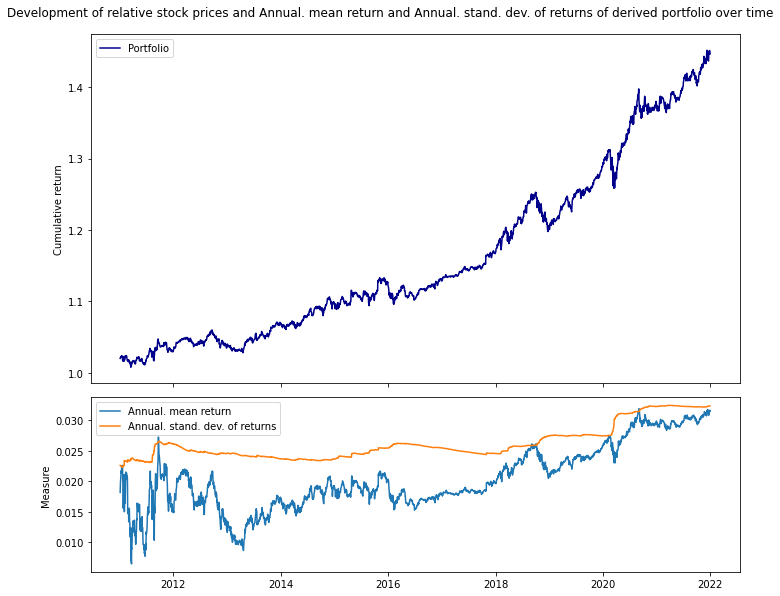

In [ ]:
basic_measures = measure_over_time(compute_mean_std, [np.array(returns_sum), n_days])
plot_development_measure(basic_measures, ['Annual. mean return', 'Annual. stand. dev. of returns'], multiple = True)

The plot shows that, after some initial swing, both the standard deviation and the mean return continuously increase over time.

Now, the same calculations are performed for the old portfolio which consisted of three simple moving average signals.

In [ ]:
returns_sum_old = df_position_old.sum(axis=1)
mean_returns_old, std_returns_old = compute_mean_std([np.array(returns_sum_old), n_days])
print('Annualized mean of old portfolio: {:.5f}'.format(mean_returns_old))
print('Annualized std of old portfolio:  {:.5f}'.format(std_returns_old))

Annualized mean of old portfolio: 0.01911
Annualized std of old portfolio:  0.02085


Hence, it can be observed that our three composite signals yield a portfolio position which significantly outperforms the initial moving average signals in terms of mean return at the price of a higher volatility (risk).

In addition, the market returns $R_{M}$ are defined as they will be subsequently used.

In [ ]:
returns_sp = (df_prices['^GSPC'][1:].to_numpy() / df_prices['^GSPC'][:-1].to_numpy()) - 1

### Value-at-Risk and associated measures

The **Value-at-Risk (VaR)** provides an aggregate measure of risk by assessing worst-case scenarios.

First, we will use the historical (non-parametric) $\text{VaR}_p$ which is defined such that 

$$ 
P[r \le \text{VaR}_p] = p
$$

Hence, it portrays the p-quantile of all historical returns.

In [ ]:
# defining function to comput VaR depending on quantile
def VaR(args):
    prices, p = args[0], args[1]

    prices = sorted(prices)
    q = 1-p
    idx_q = int(q*len(prices)) # compute index of quantile
    return prices[idx_q]

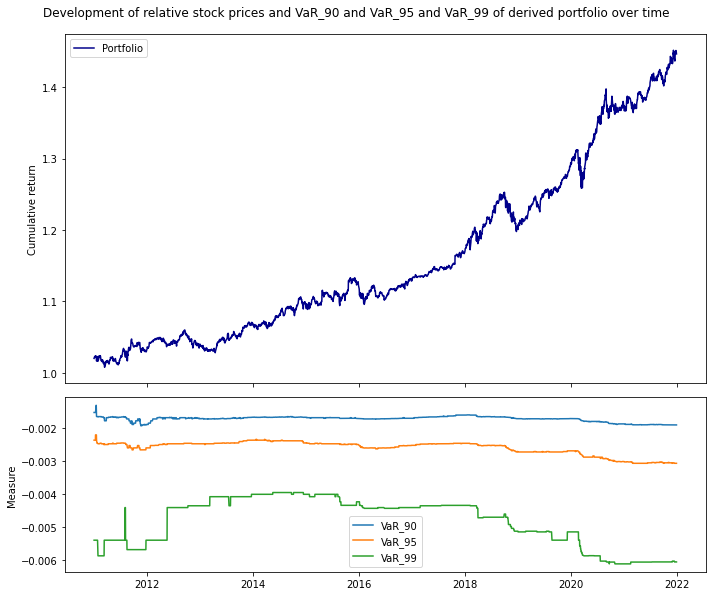

In [ ]:
ps = [0.9, 0.95, 0.99]
vars = [measure_over_time(VaR, [returns, p]) for p in ps]
vars_zip = [[vars[v][i] for v in range(len(vars))] for i in range(len(vars[0]))]
plot_development_measure(vars_zip, ['VaR_90', 'VaR_95', 'VaR_99'], multiple = True)

Intuitively, the 99%-Var presents the most volatile of the three measures because it is most senstive to outliers.

The interpretation is as follow: \\
In the worst **ten percent** of all days, we will experience a daily return 
of approximately -0.2% or worse. <br>
In the worst **five percent** of all days, we will experience a daily return of approximately -0.3% or worse. <br>
In the worst **one percent** of all days, we will experience a daily return of approximately -0.6% or worse.

Next, we want to compare the non-parametric VaRs to the parametric ones. For that, we fit a normal distribution with the daily mean return and standard deviation. By doing so, we can then compute the same VaRs using the fitted distribution.

Also, we plot a kernel density estimation for the portfolio returns.

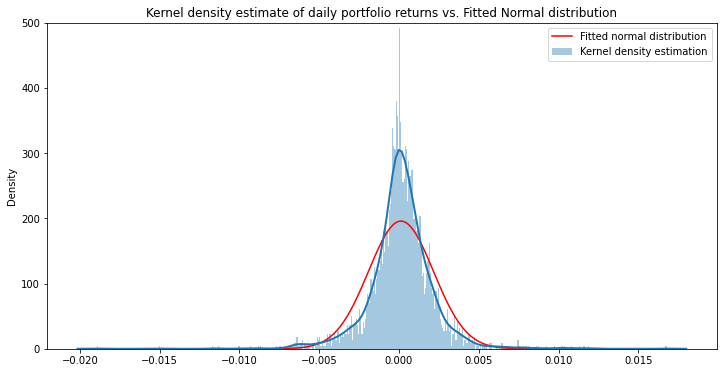


Historical VaR for 90%-Confidence interval: -0.001913 as opposed to the 90.0%-Confidence interval for the normal distribution: -0.002488

Historical VaR for 95%-Confidence interval: -0.003067 as opposed to the 95.0%-Confidence interval for the normal distribution: -0.003228

Historical VaR for 99%-Confidence interval: -0.006048 as opposed to the 99.0%-Confidence interval for the normal distribution: -0.004617


In [ ]:
plt.figure(figsize=(12,6))

# compute daily mean return and standard deviation
mean_ret = np.sum(returns) / len(returns)
std_ret = np.sqrt(np.sum(np.square(returns - mean_ret)) / (len(returns) -1))

x = np.linspace(mean_ret - 4*std_ret, mean_ret+4*std_ret, 3020)

# plotting normal distribution with mean and std of daily portfolio returns
plt.plot(x, stats.norm.pdf(x, mean_ret, std_ret), "r", label = "Fitted normal distribution")

# plotting kernel density estimate of daily portfolio returns
sns.distplot(returns,hist=True, kde=True, 
             bins=500, kde_kws={'linewidth': 2}, label = 'Kernel density estimation')

plt.legend()
plt.ylim((0,500))
plt.title("Kernel density estimate of daily portfolio returns vs. Fitted Normal distribution")
plt.show()

# compute VaRs for daily portfolio returns and normal distribution
ps = [0.9, 0.95, 0.99]
for p in ps:
  print('\nHistorical VaR for {}%-Confidence interval: {:.4} as opposed to the {}%-Confidence interval for the normal distribution: {:.4}'\
  .format(int(p*100), VaR([returns, p]), p*100, stats.norm.ppf(1-p, mean_ret, std_ret)))

Comparing the historical 95%-VaR and the one computed based on a fitted normal distribution, it can be seen that they only deviate slightly. In fact, the 90%-VaR and 95%-VaR are smaller than the same quantiles computed for the normal distribution while the 99%-VaR is bigger than the 99%-quantile of the normal distribution. This indicates a positive kurtosis for the portfolio return distribution. Extremely negative events are therefore more likely than a normal distribution would predict ("fat tail" phenomenon).

To confirm this, we calculate the (unbiased) kurtosis ($\kappa$) and skewness ($\gamma$) of our return distribution.

$$
\kappa = \frac{(n+1)*n}{(n-1)*(n-2)*(n-3)} * \frac{\sum_{i} (r_i - \bar{r})^4}{\sigma_r^4}
$$
 \\

$$
\gamma = \frac{\sqrt{n*(n-1)}}{(n-2)} * \frac{\frac{1}{n} \sum_{i=1}^n (r_i - \bar{r})^3}{\left(\frac{1}{n} \sum_{i=1}^n (r_i - \bar{r})^2 \right)^{1.5}}
$$

In [ ]:
# calculate kurtosis
n = len(returns)
sum_term = sum((returns-mean_ret)**4)
factor = ((n+1) * n) / ((n-1) * (n-2) * (n-3))
kurtosis = factor * sum_term / std_ret**4
print('Kurtosis: {:.4}'.format(kurtosis))

# calculate skewness
m2 = sum((returns-mean_ret)**2) / n
m3 = sum((returns-mean_ret)**3) / n
skew = (np.sqrt(n*(n-1))/ (n-2)) * (m3 / m2 ** 1.5)
print('Skewness: {:.4}'.format(skew))

Kurtosis: 12.15
Skewness: -0.1728


Considering the kurtosis and skewness of our portfolio returns, how previous hypotheses are confirmed as the kurtosis is significantly higher than the one of the normal distribution (kurtosis = 3) and the return distribution is negatively skewed.

Lastly, we visualize the 95%-VaR for both the non-parametric and the parametric VaR method.

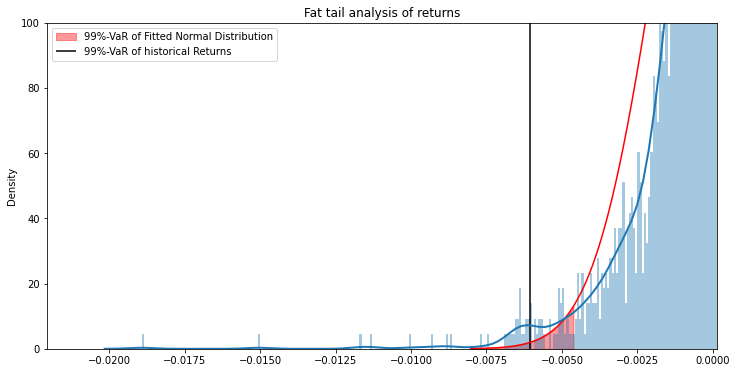

In [ ]:
p = 0.99

var_95_nd = stats.norm.ppf(1-p, mean_ret, std_ret)
x_nd = x[x < var_95_nd]

var_95_hist = VaR([returns, p])

plt.figure(figsize=(12,6))

# plotting normal distribution with mean and std of daily portfolio returns
plt.plot(x, stats.norm.pdf(x, mean_ret, std_ret), "r")

# plotting kernel density estimate of daily portfolio returns
sns.distplot(returns,hist=True, kde=True, 
             bins=500, kde_kws={'linewidth': 2})

# visualize VaRs
plt.fill_between(x_nd, stats.norm.pdf(x_nd, mean_ret, std_ret), color="r", alpha=0.4, label = f'{int(p*100)}%-VaR of Fitted Normal Distribution')
plt.vlines(var_95_hist, 0, 100, label = f'{int(p*100)}%-VaR of historical Returns')

plt.legend()
plt.ylim((0,100))
plt.xlim(right=mean_ret)
plt.title("Fat tail analysis of returns")
plt.show()

This plot visualizes the previously made statement that the fitted normal distribution understimates the 99%-VaR, due to the "fat tail" risk of the portfolio returns.

### Jensen's Alpha

**Jensen's Alpha $\alpha_{j}$** determines the abnormal return of a portfolio of securities over the theoretical expected return. It is based on the standard alpha $\alpha_{i}$ used in capital asset pricing models to compute an asset's active return and its out- or underperformance of the market index it is compared to. One could also say that the asset therefore earned too much/too little for the risk it is associated with.

Applying the same concept to a portfolio rather than a single investment leads to Jensen's Alpha, which gives the out- or underperformance of a portfolio compared to the theoretical return of a risk-free asset and a benchmark portfolio with an identical beta-factor to the portfolio's $\beta _ p$.

In a CAPM setting, it is defined as:

$$
\alpha_{J} =R_{P}-\left (R_{f}+\beta_p \left ( R_{M} -R_{f}\right ) \right )
$$

In [ ]:
def jensens_alpha(args):
    returns, benchmark_returns, risk_free_rate, n_days = args[0], args[1], args[2], args[3]

    # compute mean returns of portfolio and market
    mean_returns = np.sum(returns) / len(returns)
    mean_returns_benchmark = np.sum(benchmark_returns) / len(benchmark_returns)

    # compute resulting annualized variance of market and covariance with the portfolio returns
    var_ann_returns_benchmark = np.sum(np.square(benchmark_returns - mean_returns_benchmark)) / (len(benchmark_returns)-1) * n_days
    cov_position_to_benchmark = np.sum((returns-mean_returns)*(benchmark_returns-mean_returns_benchmark)) / (len(benchmark_returns)-1) * n_days

    # compute resulting beta and alpha
    beta_position = cov_position_to_benchmark/var_ann_returns_benchmark
    alpha = mean_returns*n_days - (risk_free_rate + beta_position*(mean_returns_benchmark*n_days - risk_free_rate))
    return alpha, beta_position


jensens_alpha_p, beta_p = jensens_alpha([returns, returns_sp, avg_ann_rf, n_days])
print('Jensen\'s alpha: {:.5f}'.format(jensens_alpha_p))
print('Beta: {:.5f}'.format(beta_p))

Jensen's alpha: 0.00804
Beta: 0.14363


Hence, it can be said that our portfolio very marginally outperforms the theoretical expected return based on the S&P 500 as a benchmark portfolio and therefore has a return in excess of the reward for the assumed risk.

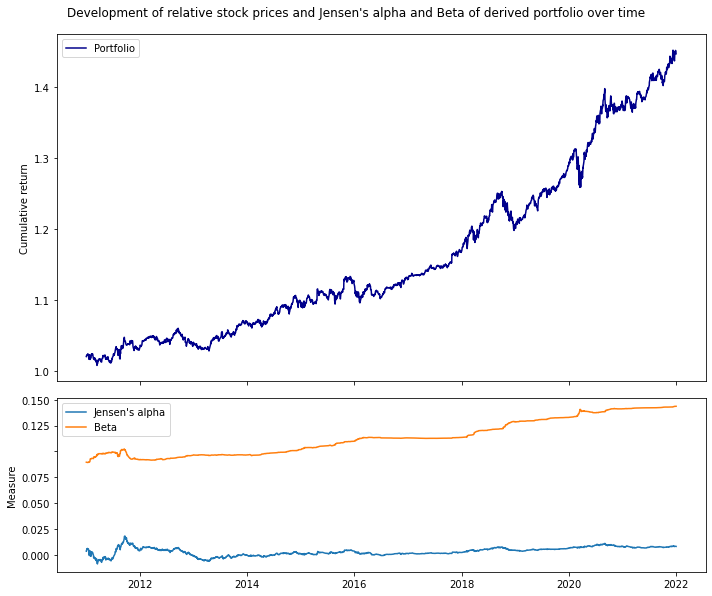

In [ ]:
jas = measure_over_time(jensens_alpha, [returns, returns_sp, avg_ann_rf, n_days])
plot_development_measure(jas, ['Jensen\'s alpha', 'Beta'], multiple = True)

This is further supported by the development of Jensen's $\alpha$ over time. On the other hand, the $\beta$ slightly increases over time.

The constructed portfolio has a relatively low positive $\beta$ and therefore, low correlation with the S&P 500. This could be explained by the fact that the investigated stocks, especially AAPL and AMZN, had very extreme price movements compared to the S&P 500 in particular in recent years. Furthermore, the portfolio is formed by investing and divesting in the stocks which means the portfolio does not consist of all three stocks at all times. Also, we only use a relatively small capital fraction per trade. Considering these facts, it is a positive sign that the portfolio has a comparably low $\beta$ as this indicates that the portfolio is only slightly affected by a negative movement in the market as a result of the trading strategies applied.

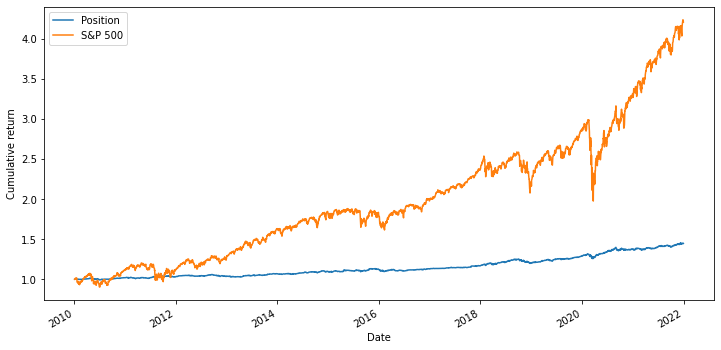

In [ ]:
df_position.sum(axis=1).plot(label = 'Position', legend = True)
(df_prices['^GSPC'] / df_prices['^GSPC'][0]).plot(label = 'S&P 500', figsize = (12,6), legend = True, ylabel='Cumulative return');

Contrasting the development of our portfolio position and the S&P 500 underlines the previously made claim that our portfolio is more stable in its development and generally, not a high correlation between the two time series would be assumed.

### Sharpe Ratio

The **Sharpe Ratio** measures the performance of a security or portfolio in comparison to a risk-free asset, after adjusting for its associated risk. Therefore, it represents the excess return of the investment per unit of risk and is defined as:

$$
SR = \frac{R_p - R_f}{\sigma_p}
$$

In [ ]:
def sharpe_ratio(args):
    returns, risk_free_rate, n_days = args[0], args[1], args[2]

    # Calculate Average Annual Return
    mean_ann_return = sum(returns) / len(returns) * n_days
    
    # Calculate Standard Deviation
    std = stddev(returns) * np.sqrt(n_days) # re-use stddev() from before

    # Compute Sharpe Ratio
    sharpe_ratio = (mean_ann_return - risk_free_rate) / std    
    return sharpe_ratio

sharpe_ratio_p = sharpe_ratio([returns, avg_ann_rf, n_days])
print('Sharpe ratio: {:.5f}'.format(sharpe_ratio_p))

Sharpe ratio: 0.82591


As can be seen, our portfolio has at the end of the observed time frame a relatively high, positive Sharpe ratio indicating a rather well-managed balance of returns and risk, if only the volatility is considered. The portfolio almost reaches a ratio of 1, which would mean that with every additional unit of risk an additional unit of excess return is obtained as well.

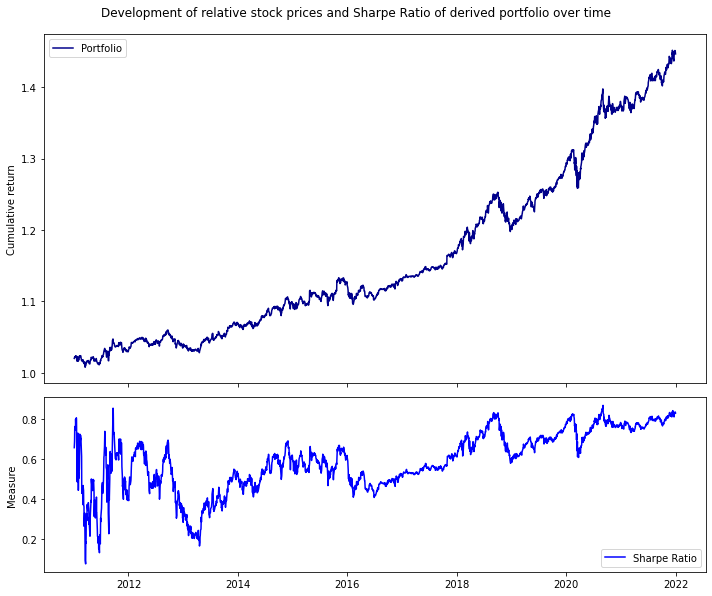

In [ ]:
srs = measure_over_time(sharpe_ratio, [returns, avg_ann_rf, n_days])
plot_development_measure(srs, 'Sharpe Ratio')

While the Sharpe Ratio is subject to string swings at beginning (might be due to the lower number of considered returns), it stabilizes and rises towards the end of time period. Also, it can be seen how the periods of downturns of the portfolio position and the Sharpe Ratio match, which they do by definition.

### Treynor Ratio

The **Treyner Ratio** measures the excess return of an asset ( $\beta _ i$) or portfolio per unit of market risk ($\beta _ p$) indicating the correlation with the overall market and is defined as:

$$
TR = \frac{R_p - R_f}{\beta_{p}}
$$

Like the Sharpe Ratio it measures excess return in comparison to the associated risk, however using the market risk instead of the volatility.

In [ ]:
def treynor_ratio(args):
    returns, benchmark_returns, risk_free_rate, n_days = args[0], args[1], args[2], args[3]

    mean_returns = sum(returns)/len(returns)
    mean_returns_benchmark = np.sum(benchmark_returns) / len(benchmark_returns)

    # compute resulting annualized variance of market and covariance with the portfolio returns  
    var_ann_returns_benchmark = np.sum(np.square(benchmark_returns - mean_returns_benchmark)) / (len(benchmark_returns)-1) * n_days
    cov_position_to_benchmark = np.sum((returns-mean_returns)*(benchmark_returns-mean_returns_benchmark)) / (len(benchmark_returns)-1) * n_days

    # compute resulting beta
    beta_position = cov_position_to_benchmark/var_ann_returns_benchmark

    # compute treyner ratio
    tr = (mean_returns*n_days - risk_free_rate) / beta_position 
    return tr

treynor_ratio_p = treynor_ratio([returns, returns_sp, avg_ann_rf, n_days])
print('Treynor Ratio: {:.5f}'.format(treynor_ratio_p))

Treynor Ratio: 0.18605


The positive Treyner Ratio shows that an excess return is earned for the market risk taken. The value shown is the annual excess return the portfolio would be expected to earn if its $\beta _ p$ would be equal to 1.

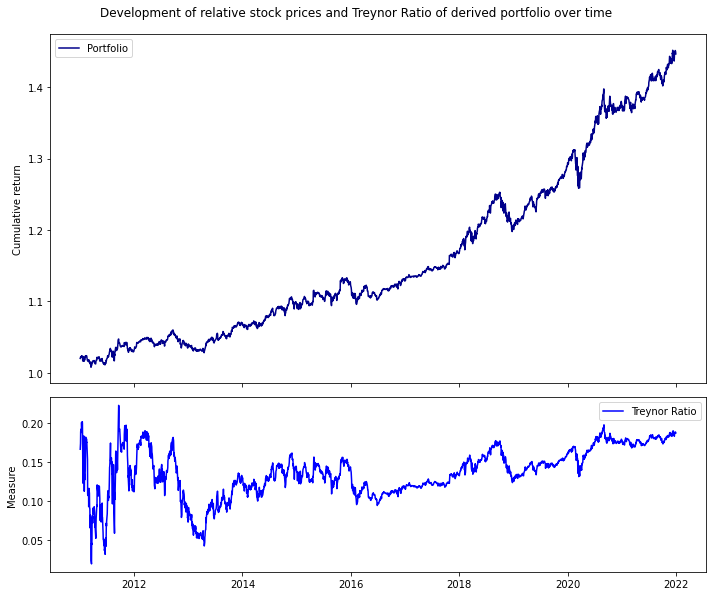

In [ ]:
trs = measure_over_time(treynor_ratio, [returns, returns_sp, avg_ann_rf, n_days])
plot_development_measure(trs, 'Treynor Ratio')

The Trynor Ratio embodies a similar development as the Sharpe Ratio in terms of upward and downward periods.

### Sortino Ratio

The **Sortino Ratio** indicates the risk-adjusted return of an asset or portfolio, after adjusting only for its downside risk. In that sense, it is a modification of the Sharpe Ratio that penalizes only downside movements and is defined as:

$$
SR= \frac{R_p - R_f}{\sigma_{d}}
$$

where $\sigma_{d}$ presents the standard deviation of negative returns only

In [ ]:
def sortino_ratio(args):
    returns, risk_free_rate, n_days = args[0], args[1], args[2]

    mean_ann_return = sum(returns) / len(returns) * n_days

    # compute \sigma_d by using the standard deviation of negative returns
    neg_returns = returns[returns < 0]
    mean_neg_returns = np.sum(neg_returns) / len(neg_returns)
    sigma_downside = np.sqrt(np.sum(np.square(neg_returns - mean_neg_returns)) / len(neg_returns)) * np.sqrt(n_days) # to annualize

    # compute sortino ratio
    sr = (mean_ann_return - risk_free_rate) / sigma_downside 
    return sr

sortino_ratio_p = sortino_ratio([returns, avg_ann_rf, n_days])
print('Sortino Ratio: {:.5f}'.format(sortino_ratio_p))

Sortino Ratio: 1.05745


As expected, the Sortino Ratio is higher than the earlier computed Sharpe Ratio since only downside volatility is considered and therefore, the denominator should be smaller in comparison to the Sharpe Ratio. However, even though only negative returns are taken for the volatility the ratios do not differ considerably which means that downside and regular volatility are similarly large. This would lead to the conclusion that the return distribution of the portfolio is negatively skewed. As we have seen before in our calculation, this is also the case.

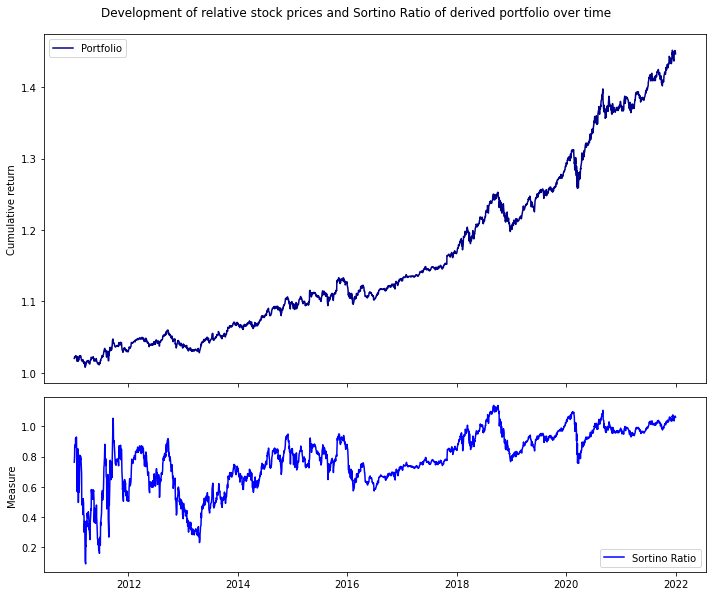

In [ ]:
srs = measure_over_time(sortino_ratio, [returns, avg_ann_rf, n_days])
plot_development_measure(srs, 'Sortino Ratio')

The development of the Sortino Ratio can be interpreted analogously to the previous measures.

### Calmar Ratio (Drawdown Ratio)


The **Calmar Ratio** measures the excess return of an asset or a portfolio in comparison to its historical maximum drawdown (maximum decline from a peak) of its returns as a risk measure and is defined as:

$$
CR = \frac{R_p - R_f}{\text{MaxDD}}
$$

A **negative Calmar ratio** would mean that the risk-free rate is higher than the portfolio's returns. 

A **ratio from 0 to 1.0** indicates that the portfolio's excess returns do not exceed the maximum drawdown for a given period while a **ratio of more than 1.0** shows that the returns slightly exceed the drawdown. This investment could be considered risky.

A **Calmar ratio above 3.0** shows that the excess returns significantly exceed the drawdown which could be an indicator of a sound investment.

In [ ]:
# helper function to compute the cumulative maximum value of a series
def cummax(series):
    output_lst = []
    current_max = 0
    for p in series:
      if p > current_max:
        current_max = p
      output_lst.append(current_max)

    return output_lst

# helper function to determine maximum drawdown of returns
def max_drawdown(pos):
    # divide position by cumulative maximum (highest maximum so far) and subtract 1
    pos_cummax = cummax(pos)
    dd =  pos / pos_cummax - 1
    
    # deduce the maximum drawdown
    mdd = dd.min()
    return abs(mdd)

def calmar_ratio(args):
    returns, pos, risk_free_rate, n_days = args[0], args[1], args[2], args[3]

    #compute annualized mean return and max. drawdown
    mean_ann_return = sum(returns) / len(returns) * n_days
    max_dd = max_drawdown(pos)

    # compute calmar ratio
    cr = (mean_ann_return - risk_free_rate) / max_dd
    return cr

calmar_ratio_p = calmar_ratio([returns, returns_sum, avg_ann_rf, n_days])
print('Calmar ratio: {:.5f}'.format(calmar_ratio_p))

Calmar ratio: 0.60895


The average below 1 ratio shows that the returns of the portfolio did not exceed the maximum drawdown in the investigated period.

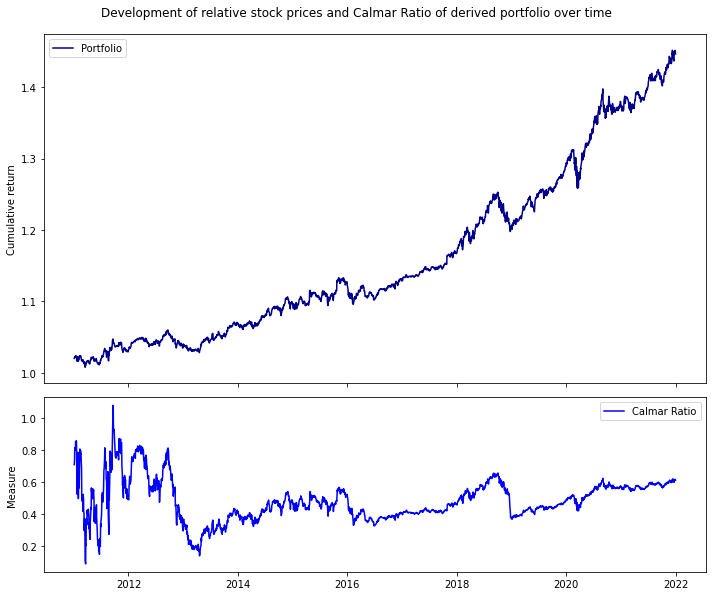

In [ ]:
crs = measure_over_time(calmar_ratio, [returns, returns_sum, avg_ann_rf, n_days])
plot_development_measure(crs, 'Calmar Ratio')

After an early peak with a value above one, the Calmar Ratio consolidates in the ball park around 0.5.

### Information Ratio

The **Information Ratio** determines the expected active return that a security or portfolio earns in comparison to a benchmark index, usually representing the market like the S&P 500 in our case, relative to the volatility of the return differences. It therefore represents the expected additional active return per unit of increase in risk and is defined as:

$$
IR = \frac{E[R_p - R_M]}{\sigma_{pm}}
$$

In [ ]:
def information_ratio(args):
    returns, benchmark_returns, n_days = args[0], args[1], args[2]
    
    return_difference = returns - benchmark_returns # compute return differences
    volatility = stddev(return_difference) * np.sqrt(n_days) # annualize standard deviation of return differences
    return_difference_mean = (sum(return_difference) / len(return_difference)) * n_days
    information_ratio = return_difference_mean / volatility
    return information_ratio

information_ratio_p = information_ratio([returns, returns_sp, n_days])
print('Information ratio: {:.5f}'.format(information_ratio_p))

Information ratio: -0.69598


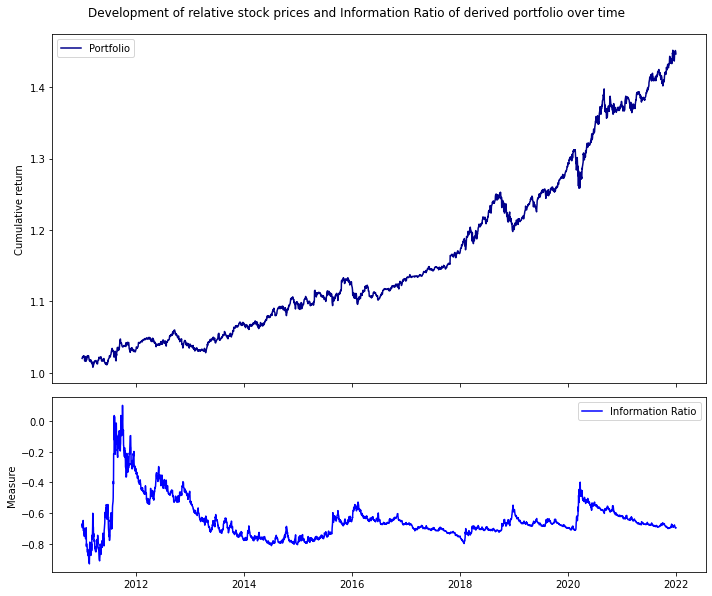

In [ ]:
irs = measure_over_time(information_ratio, [returns, returns_sp, n_days])
plot_development_measure(irs, 'Information Ratio')

Our portfolio has for the most part a negative Information Ratio indicating that the benchmark index outperforms it. Considering that the analyzed stocks outperformed the benchmark index if held for the entire time frame, as could be seen earlier, the reason for the overall negative Information Ratio could lie in the relatively small capital fraction per individual trade and the fact that stocks could not be bought again once they were already in the portfolio.

### Modigliani Ratio (M2 ratio)

The **Modigliani Ratio** measures the return of a portfolio, adjusted for the risk of the portfolio relative to that of some benchmark and is defined as:

$$
M2 = SR * \sigma_m + R_f
$$
where:
$$
SR = \frac{R_p - R_f}{\sigma_p}
$$

It is derived from the Sharpe Ratio but has the advantage of being in units of percent return and is therefore, as opposed to the Sharpe Ratio, not a dimensionless ratio which is hard to interpret but can be compared at times.

In [ ]:
def modigliani_ratio(args):
    returns, returns_benchmark, risk_free_rate, n_days = args[0], args[1], args[2], args[3]

    # compute Sharpe Ratio
    sr = sharpe_ratio([returns, risk_free_rate, n_days])

    # compute annualized volatility of benchmark returns
    benchmark_vol = stddev(returns_benchmark) * np.sqrt(n_days)

    # compute Modigliani Ratio
    m2 = (sr * benchmark_vol) + risk_free_rate
    return m2

m2_p = modigliani_ratio([returns, returns_sp, avg_ann_rf, n_days])
print('Modigliani ratio: {:.5f}'.format(m2_p))

Modigliani ratio: 0.14644


The portfolio had a 14.6% risk-adjusted return per year, with the risk adjusted to that of the benchmark portfolio, the S&P 500.

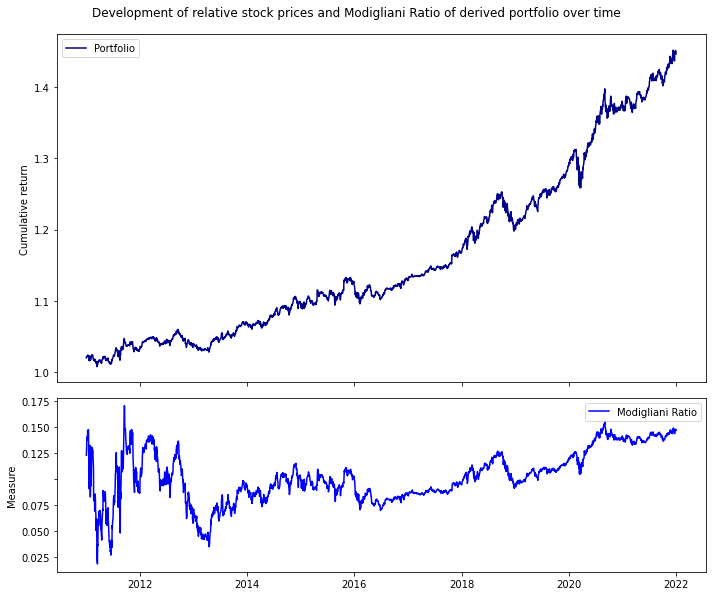

In [ ]:
mrs = measure_over_time(modigliani_ratio, [returns, returns_sp, avg_ann_rf, n_days])
plot_development_measure(mrs, 'Modigliani Ratio')

Here, we can see how the risk-adjusted return increases over time, with some fluctuations along the way.

## Graphs of Strategy <a id="IV"></a>

**Instructions**

*Compute meaningful plots of your strategy and label it in an understandable way*

### General plots of portfolio position

First, we compare the cumulative return development of our portfolio and the one from the initial three basic moving average signals.

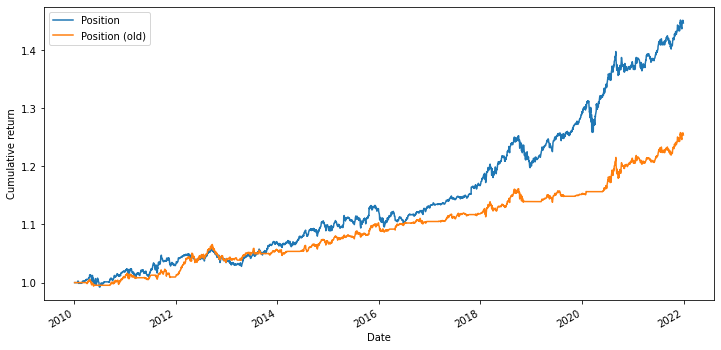

In [ ]:
df_position.sum(axis=1).plot(label = 'Position', legend = True) # cumulative returns of position
df_position_old.sum(axis=1).plot(label = 'Position (old)', legend = True, figsize = (12,6), ylabel='Cumulative return');

Here, it can be seen how our strategy continously outperforms the previous approach, in particular from 2016 onwards.

Next, we want to dive deeper into the composition of our portfolio to see which stocks fuel the cumulative return. To do, we plot the (indexed) stock developments versus our respective positions in each stock.

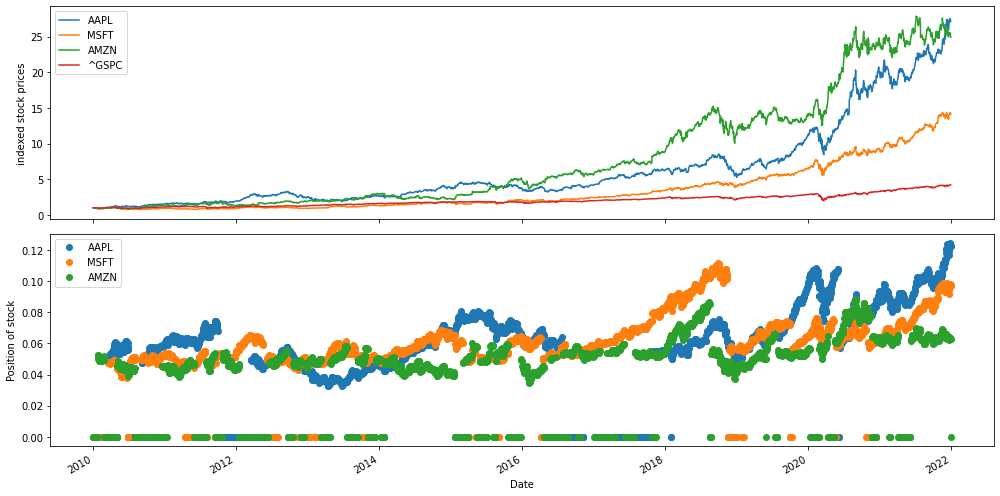

In [ ]:
idx = df_position.index

fig = plt.figure(figsize=(14,7))
# set height ratios for subplots
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

# Subplot 1: price developments
ax0 = plt.subplot(gs[0])
for stock in tickers:
    ax0.plot_date(idx, (df_prices[stock] / df_prices[stock][0]), '-', label = stock)

# Subplot 2: positions of stocks over time
ax1 = plt.subplot(gs[1])
for ticker in tickers[:-1]:
    ax1.plot_date(idx, df_position[ticker], label = ticker)

# formatting
fig.autofmt_xdate() # Auto fixes overlap
ax0.legend()
ax1.legend()
ax0.set_ylabel('indexed stock prices')
ax1.set_ylabel('Position of stock')
ax1.set_xlabel('Date')
plt.tight_layout()
plt.show()

Hence, we can see that all three stocks present important parts of our portfolio as their respective positions do not differ to a large extent. Also, we have periods of empty positions in all stocks, highlighting the processed trades.

### In-depth analysis of signals

Next, we aim to analyze each signal-stock pairing to a greater extent. To do so, we will plot the stock with the buy- and sell-signals, the position in our portfolio and the indicators associated with the respective trading signal for a variable time horizon (via adjusting `n`, the number of last days which are plotted).

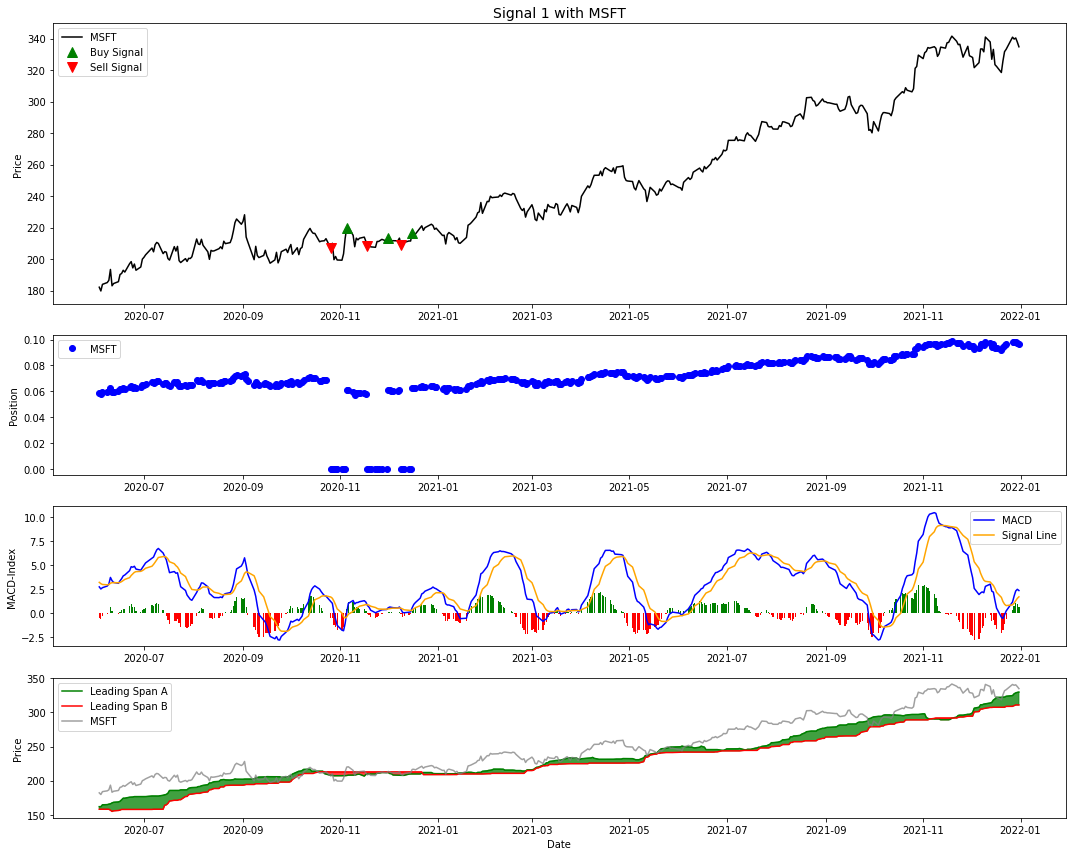

In [ ]:
# visualize signal 21

n = 400
stock = 'MSFT'
signal_func = signal_1


df_position_n = df_position.iloc[-n:,:]
df_position_changes_n = df_position_changes.iloc[-n:,:]
idx = df_position_n.index
res = signal_func(df_prices[stock])

buy_price = [df_prices[stock][i] if res['position_change'][i] == 1 else np.nan for i in range(res.shape[0])][-n:]
sell_price = [df_prices[stock][i] if res['position_change'][i] == -1 else np.nan for i in range(res.shape[0])][-n:]


fig = plt.figure(figsize=(15,12))
# set height ratios for subplots
gs = gridspec.GridSpec(4, 1, height_ratios=[2, 1, 1, 1])

# first subplot: stock price
ax0 = plt.subplot(gs[0])
line0, = ax0.plot_date(idx, df_prices[stock][-n:],'-', label = stock, color = 'black')
line1, = ax0.plot(idx, buy_price, marker = '^', color = 'green', markersize = 10, linewidth = 0, label = 'Buy Signal')
line2, = ax0.plot(idx, sell_price, marker = 'v', color = 'r', markersize = 10, linewidth = 0, label = 'Sell Signal')

# second subplot: position
ax1 = plt.subplot(gs[1], sharex = ax0)
line3 = ax1.plot_date(idx, df_position_n[stock][-n:], label = stock, color = 'blue')

# third subplot: MACD
ax2 = plt.subplot(gs[2], sharex = ax0)
diff = (res['MACD'][-n:] - res['signal_line'][-n:])
line4, = ax2.plot_date(idx, res['MACD'][-n:],'-', label = 'MACD', color = 'blue')
line5, = ax2.plot_date(idx, res['signal_line'][-n:],'-', label = 'Signal Line', color = 'orange')
line6 = ax2.bar(diff[diff > 0].index, diff[diff > 0], color = 'green')
line7 = ax2.bar(diff[diff < 0].index, diff[diff < 0], color = 'red')

# fourth subplot: Ichimoku cloud
ax3 = plt.subplot(gs[3], sharex = ax0)
df_ic = ichimoku_cloud(df_prices[stock])[-n:]
line8, = ax3.plot_date(idx, df_ic['leading_a'],'-', label = 'Leading Span A', color = 'green')
line9, = ax3.plot_date(idx, df_ic['leading_b'],'-', label = 'Leading Span B', color = 'red')
ax3.fill_between(idx, df_ic['leading_a'], df_ic['leading_b'], where=(df_ic['leading_a'] > df_ic['leading_b']), color = 'green', alpha=0.75)
ax3.fill_between(idx, df_ic['leading_a'], df_ic['leading_b'], where=(df_ic['leading_a'] < df_ic['leading_b']), color = 'red', alpha=0.75)
line10, = ax3.plot_date(idx, df_prices[stock][-n:],'-', label = stock, color = 'grey', alpha = 0.75)

# formatting plot
ax0.set_title('Signal 1 with {}'.format(stock), {'fontsize':14})
ax0.legend()
ax1.legend()
ax2.legend()
ax3.legend()

ax3.set_xlabel('Date')

ax0.set_ylabel('Price')
ax1.set_ylabel('Position')
ax2.set_ylabel('MACD-Index')
ax3.set_ylabel('Price')


# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)
plt.tight_layout()
plt.show()

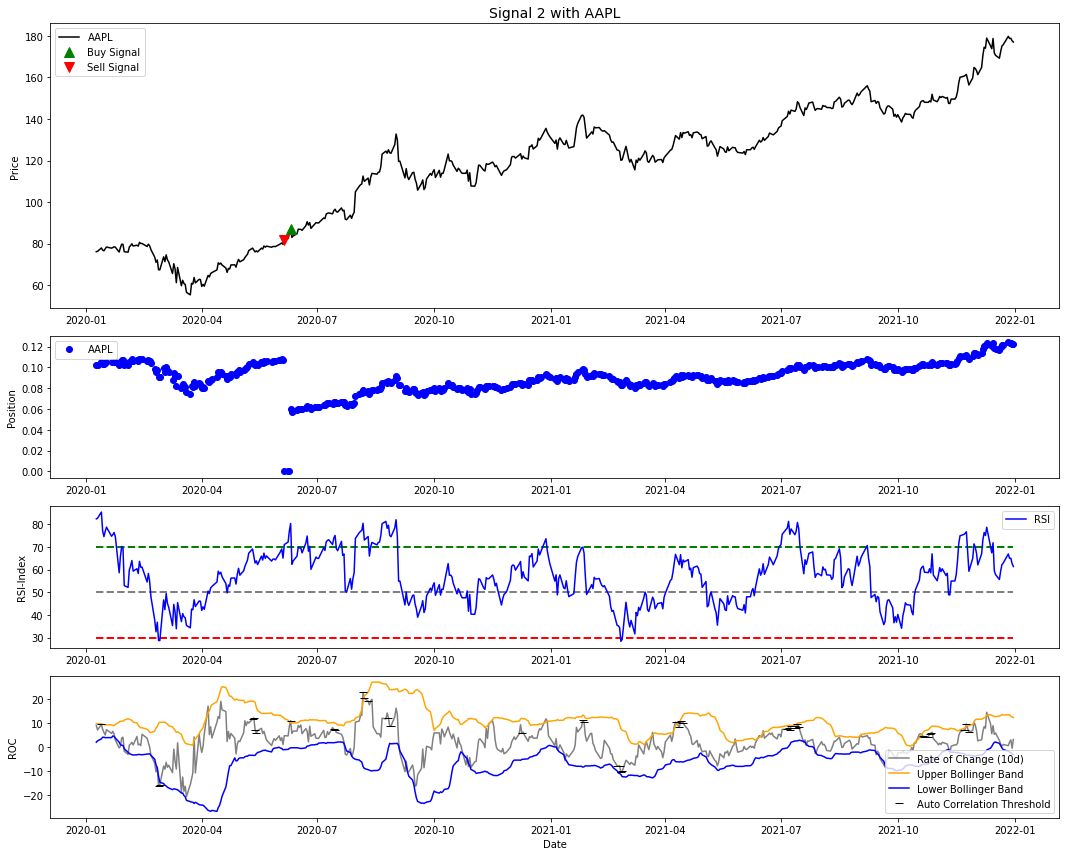

In [ ]:
# visualize signal 2

n = 500
stock = 'AAPL'
signal_func = signal_2


df_position_n = df_position.iloc[-n:,:]
df_position_changes_n = df_position_changes.iloc[-n:,:]
idx = df_position_n.index
res = signal_func(df_prices[stock])
df_fi = flashingIndicator(df_prices[stock], 10)

buy_price = [df_prices[stock][i] if res['position_change'][i] == 1 else np.nan for i in range(res.shape[0])][-n:]
sell_price = [df_prices[stock][i] if res['position_change'][i] == -1 else np.nan for i in range(res.shape[0])][-n:]


fig = plt.figure(figsize=(15,12))
# set height ratios for subplots
gs = gridspec.GridSpec(4, 1, height_ratios=[2, 1, 1, 1])

# first subplot: stock price
ax0 = plt.subplot(gs[0])
line0, = ax0.plot_date(idx, df_prices[stock][-n:],'-', label = stock, color = 'black')
line1, = ax0.plot(idx, buy_price, marker = '^', color = 'green', markersize = 10, linewidth = 0, label = 'Buy Signal')
line2, = ax0.plot(idx, sell_price, marker = 'v', color = 'r', markersize = 10, linewidth = 0, label = 'Sell Signal')

# second subplot: position
ax1 = plt.subplot(gs[1], sharex = ax0)
line3 = ax1.plot_date(idx, df_position_n[stock][-n:], label = stock, color = 'blue')

# third subplot: RSI
ax2 = plt.subplot(gs[2], sharex = ax0)
line4, = ax2.plot_date(idx, res['relative_strength_index'][-n:],'-', label = 'RSI', color = 'blue')
ax2.hlines(y=70, xmin=idx[0], xmax=idx[-1], linewidth=2, color='g', linestyles = '--')
ax2.hlines(y=30, xmin=idx[0], xmax=idx[-1], linewidth=2, color='r', linestyles = '--')
ax2.hlines(y=50, xmin=idx[0], xmax=idx[-1], linewidth=2, color='grey', linestyles = '--')

# fourth subplot: Flashing indicator with minor trend
ax3 = plt.subplot(gs[3], sharex = ax0)
line5 = ax3.plot_date(idx, df_fi['ROC'][-n:], '-', label = 'Rate of Change (10d)', color = 'grey')
line6 = ax3.plot_date(idx, df_fi['Bollinger Up'][-n:], '-', label = 'Upper Bollinger Band', color = 'orange')
line7 = ax3.plot_date(idx, df_fi['Bollinger Down'][-n:], '-', label = 'Lower Bollinger Band', color = 'blue')
line8 = ax3.plot(idx, np.where(df_fi['Autocorrelation'] > 0.9, df_fi['ROC'], None)[-n:], marker = '_', color = 'black', markersize = 8, linewidth = 0, label = 'Auto Correlation Threshold')


# formatting plot
ax0.set_title('Signal 2 with {}'.format(stock), {'fontsize':14})

ax0.legend()
ax1.legend()
ax2.legend()
ax3.legend()

ax3.set_xlabel('Date')

ax0.set_ylabel('Price')
ax1.set_ylabel('Position')
ax2.set_ylabel('RSI-Index')
ax3.set_ylabel('ROC')

# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)
plt.tight_layout()
plt.show()

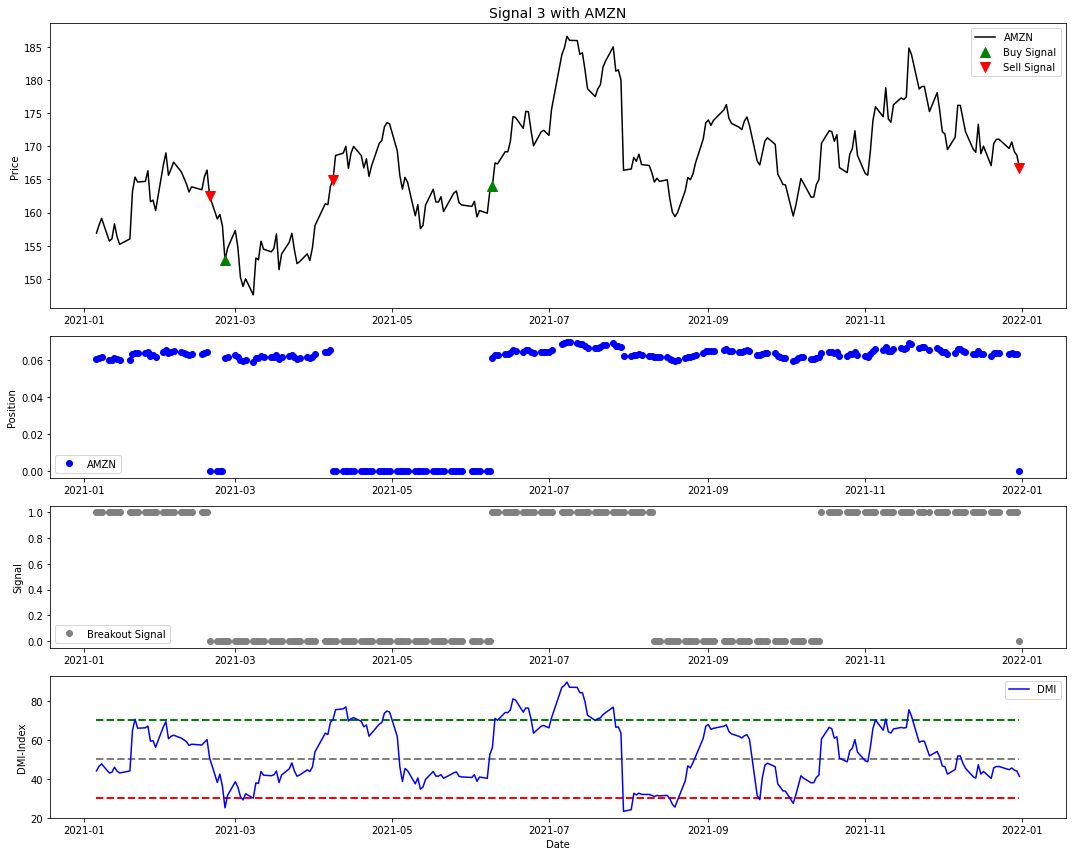

In [ ]:
## visualize signal 3

n = 250
stock = 'AMZN'
signal_func = signal_3


df_position_n = df_position.iloc[-n:,:]
df_position_changes_n = df_position_changes.iloc[-n:,:]
idx = df_position_n.index
res = signal_func(df_prices[stock])

buy_price = [df_prices[stock][i] if res['position_change'][i] == 1 else np.nan for i in range(res.shape[0])][-n:]
sell_price = [df_prices[stock][i] if res['position_change'][i] == -1 else np.nan for i in range(res.shape[0])][-n:]


fig = plt.figure(figsize=(15,12))
# set height ratios for subplots
gs = gridspec.GridSpec(4, 1, height_ratios=[2, 1, 1, 1])

# first subplot: stock price
ax0 = plt.subplot(gs[0])
line0, = ax0.plot_date(idx, df_prices[stock][-n:],'-', label = stock, color = 'black')
line1, = ax0.plot(idx, buy_price, marker = '^', color = 'green', markersize = 10, linewidth = 0, label = 'Buy Signal')
line2, = ax0.plot(idx, sell_price, marker = 'v', color = 'r', markersize = 10, linewidth = 0, label = 'Sell Signal')

# second subplot: position
ax1 = plt.subplot(gs[1], sharex = ax0)
line3 = ax1.plot_date(idx, df_position_n[stock][-n:], label = stock, color = 'blue')

# third subplot: Trading Breakout
ax2 = plt.subplot(gs[2], sharex = ax0)
line3 = ax2.plot_date(idx, res['breakout'][-n:], label = 'Breakout Signal', color = 'grey')

# fourth subplot: Dynamic Momentum Index
ax3 = plt.subplot(gs[3], sharex = ax0)
line1, = ax3.plot_date(idx, res['dynamic_momentum_index'][-n:],'-', label = 'DMI', color = 'blue')
ax3.hlines(y=70, xmin=idx[0], xmax=idx[-1], linewidth=2, color='g', linestyles = '--')
ax3.hlines(y=30, xmin=idx[0], xmax=idx[-1], linewidth=2, color='r', linestyles = '--')
ax3.hlines(y=50, xmin=idx[0], xmax=idx[-1], linewidth=2, color='grey', linestyles = '--')


# formatting plot
ax0.set_title('Signal 3 with {}'.format(stock), {'fontsize':14})

ax0.legend()
ax1.legend()
ax2.legend()
ax3.legend()

ax3.set_xlabel('Date')

ax0.set_ylabel('Price')
ax1.set_ylabel('Position')
ax2.set_ylabel('Signal')
ax3.set_ylabel('DMI-Index')

# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)
plt.tight_layout()
plt.show()

These plots show how our `generate_signal()` function combines the two indicators in the correct way to derive the ultimate signals which are used for trading. One can also see, how out signals are generally capable to find good entry and exit spots.

### Analysis of returns

Finally, we aim to analyze our daily returns in greater detail. To do so, we derive the returns associated with each signal/stock and plot them along with the portfolio returns. In addition, we plot the respective kernel density estimates on the y-axis.

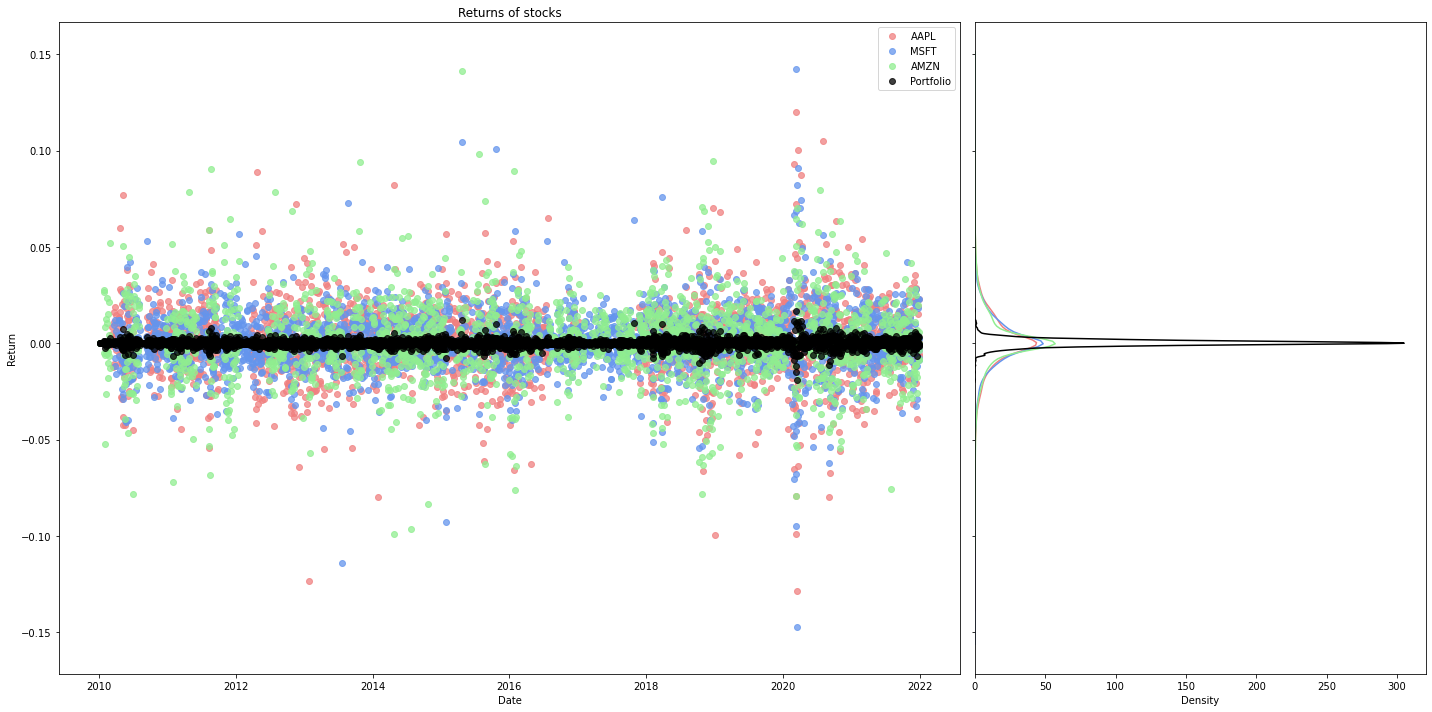

In [ ]:
# compute returns of stock positions (if applicable)
def analyze_stock_signal(idx):
  pos = df_position.iloc[:,idx]
  returns = [0]
  for i in range(1, len(pos)):
    if pos[i-1] == 0 or pos[i] == 0:
      returns.append(0)

    else:
      returns.append((pos[i]/pos[i-1])-1)
  return returns


# plot returns
idx = df_position.index

f, axs = plt.subplots(1,2,
                      figsize=(20,10),
                      sharey=True,
                      gridspec_kw=dict(width_ratios=[3,1.5]))

colors = ['lightcoral', 'cornflowerblue', 'lightgreen']
for i in range(3):
    stock_ret = analyze_stock_signal(i)
    axs[0].plot_date(idx, analyze_stock_signal(i), label = tickers[i], color = colors[i], alpha = 0.75)
    sns.kdeplot(y= stock_ret,
                ax=axs[1],
                color = colors[i],
                legend=False)

# add a 0 for the very first return
axs[0].plot_date(idx, [0]+list(returns), label = 'Portfolio', color = 'black', alpha = 0.75)
sns.kdeplot(y=[0]+list(returns),
            ax=axs[1],
            legend=False,
            color = 'black')

fig.autofmt_xdate()

axs[0].set_xlabel('Date')
axs[0].set_ylabel('Return')

axs[0].set_title('Returns of stocks')
axs[0].legend()
plt.tight_layout()
plt.show()

Here, it becomes apparent that the stock returns are significantly more volatile than the ones from our portfolio which are more stable and concentrated around zero. Also, the period of relatively large swings in early-2020 stands out.

## Additional Considerations <a id="V"></a>

### Beyond binary signals

In addition, we experimented with the case of having not only binary signals (being in position or not), but rather being flexible in the shorting and re-purchase of stocks by using the labels `[-1,0,1,2]`. 

Exemplarily, this strategy is tried out using the RSI by providing three different boundaries based on which buying and selling takes place (see below). This new signal is in turn applied to all three stocks.

We contrast this new method with the binary 0-1 RSI and apply both approaches to all three stocks (same allocation) such that their results are comparable.

In [ ]:
def signal_rsi_binary(series):
    # Init
    signals = pd.DataFrame(index = series.index)
    signals['signal'] = 0.0

    # Compute relative strength index
    window = 14
    signals['relative_strength_index'] = relative_strength_index(series)
    signals['signal'][window:] = generate_rsi_signal(signals['relative_strength_index'][window:], 30, 70)
    
    signals['position_change'] = signals['signal'].diff()
    signals.loc[series.index[0], 'position_change'] = 0
    return signals

# Compute signals and position
signals_binary = {}
signals_binary[tickers[0]] = signal_rsi_binary(df_prices[tickers[0]])
signals_binary[tickers[1]] = signal_rsi_binary(df_prices[tickers[1]])
signals_binary[tickers[2]] = signal_rsi_binary(df_prices[tickers[2]])
df_position_open_binary = pd.concat([
    signals_binary[tickers[0]]['signal'].rename(tickers[0]),
    signals_binary[tickers[1]]['signal'].rename(tickers[1]),
    signals_binary[tickers[2]]['signal'].rename(tickers[2])], axis = 1)
df_position_changes_binary = pd.concat([
    signals_binary[tickers[0]]['position_change'].rename(tickers[0]),
    signals_binary[tickers[1]]['position_change'].rename(tickers[1]),
    signals_binary[tickers[2]]['position_change'].rename(tickers[2])], axis = 1)

position_binary = []
is_first = True
for idx, position_change in df_position_changes_binary.iterrows():
    if is_first:
        position_binary.append(open_trades(np.concatenate((np.zeros(len(df_position_changes_binary.columns)), [initial_cash])), position_change))
        is_first = False
    else:
        hlpr_pos = hold_trades(position_binary[-1], df_price_changes.loc[[idx]].to_numpy()[0])
        hlpr_pos = close_trades(hlpr_pos, position_change)
        position_binary.append(open_trades(hlpr_pos, position_change))

df_position_binary = pd.DataFrame(position_binary, index = df_prices.index, columns = tickers[:-1] + ['cash'])


# compute returns and basic portfolio performance measures
returns_sum_binary = df_position_binary.sum(axis=1)
returns_binary = (returns_sum_binary[1:].to_numpy() / returns_sum_binary[:-1].to_numpy()) - 1 # (price today / price yesterday   - 1)
mean_returns_binary = np.sum(returns_binary) / len(returns_binary)
std_returns_binary = np.sqrt(np.sum(np.square(returns_binary - mean_returns_binary)) / len(returns_binary))
print('Annualized new mean: ' + str(mean_returns_binary * n_days))
print('Annualized new std:  ' + str(std_returns_binary * np.sqrt(n_days)))

Annualized new mean: 0.015136799114722828
Annualized new std:  0.01550254191046736


In [ ]:
# define new signal

def signal_rsi(series):
    # Init
    signals = pd.DataFrame(index = series.index)
    signals['signal'] = 0.0
    
    # Compute relative strength index
    window = 14
    signals['relative_strength_index'] = relative_strength_index(series)

    # Compute signal based on new boundaries
    signals['signal'][window:] = np.select([signals['relative_strength_index'][window:] < 30,
                                           (signals['relative_strength_index'][window:] > 30) & (signals['relative_strength_index'][window:] < 50),
                                           (signals['relative_strength_index'][window:] > 50) & (signals['relative_strength_index'][window:] < 70),
                                            signals['relative_strength_index'][window:] > 70], 
                                           [2, 1, 0, -1])
    
    signals['position_change'] = signals['signal'].diff()
    signals.loc[series.index[0], 'position_change'] = 0
    return signals

# Compute signals and position
signals_new = {}
signals_new[tickers[0]] = signal_rsi(df_prices[tickers[0]])
signals_new[tickers[1]] = signal_rsi(df_prices[tickers[1]])
signals_new[tickers[2]] = signal_rsi(df_prices[tickers[2]])
df_position_open_new = pd.concat([
    signals_new[tickers[0]]['signal'].rename(tickers[0]),
    signals_new[tickers[1]]['signal'].rename(tickers[1]),
    signals_new[tickers[2]]['signal'].rename(tickers[2])], axis = 1)
df_position_changes_new = pd.concat([
    signals_new[tickers[0]]['position_change'].rename(tickers[0]),
    signals_new[tickers[1]]['position_change'].rename(tickers[1]),
    signals_new[tickers[2]]['position_change'].rename(tickers[2])], axis = 1)

position_new = []
is_first = True
for idx, position_change in df_position_changes_new.iterrows():
    if is_first:
        position_new.append(open_trades(np.concatenate((np.zeros(len(df_position_changes_new.columns)), [initial_cash])), position_change))
        is_first = False
    else:
        hlpr_pos = hold_trades(position_new[-1], df_price_changes.loc[[idx]].to_numpy()[0])
        hlpr_pos = close_trades(hlpr_pos, position_change)
        position_new.append(open_trades(hlpr_pos, position_change))

df_position_new = pd.DataFrame(position_new, index = df_prices.index, columns = tickers[:-1] + ['cash'])


# compute returns and basic portfolio performance measures
returns_sum_new = df_position_new.sum(axis=1)
returns_new = (returns_sum_new[1:].to_numpy() / returns_sum_new[:-1].to_numpy()) - 1 # (price today / price yesterday   - 1)
mean_returns_new = np.sum(returns_new) / len(returns_new)
std_returns_new = np.sqrt(np.sum(np.square(returns_new - mean_returns_new)) / len(returns_new))
print('Annualized new mean: ' + str(mean_returns_new * n_days))
print('Annualized new std:  ' + str(std_returns_new * np.sqrt(n_days)))

Annualized new mean: 0.02908159445880456
Annualized new std:  0.026653919584096363


Hence, it can be seen that this more flexible approach results in a significantly higher (almost double) annualized mean return compared to the binary RSI when applied to all three stocks.

To gain a deeper understanding into the trade mechanisms, both signals are exemplarily plotted for **AAPL**.

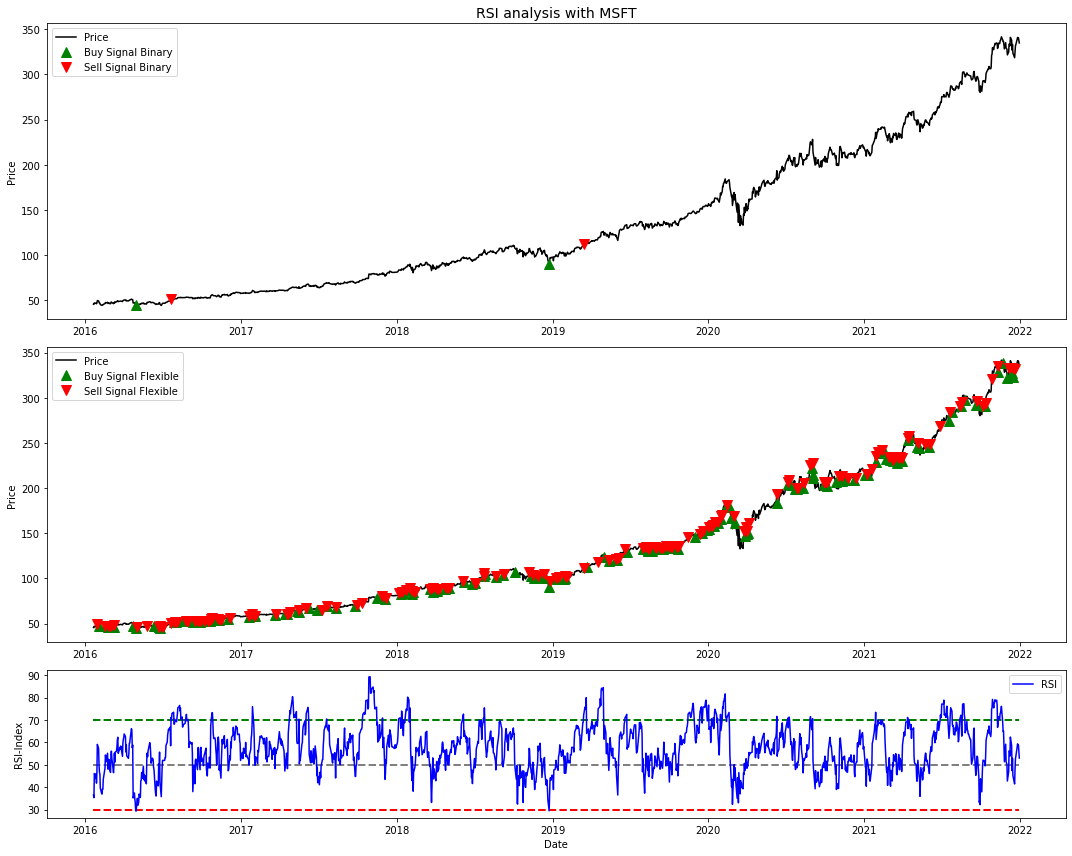

In [ ]:
n = 1500
ticker = 1

idx = df_position_binary.index[-n:]

# values for binary position
res_binary = signal_rsi_binary(df_prices[tickers[ticker]])
buy_price_binary = [df_prices[tickers[ticker]][i] if res_binary['position_change'][i] == 1 else np.nan for i in range(res_binary.shape[0])][-n:]
sell_price_binary = [df_prices[tickers[ticker]][i] if res_binary['position_change'][i] == -1 else np.nan for i in range(res_binary.shape[0])][-n:]

# values for flexible position
res_flexible = signal_rsi(df_prices[tickers[ticker]])
buy_price_flexible = [df_prices[tickers[ticker]][i] if res_flexible['position_change'][i] == 1 else np.nan for i in range(res_flexible.shape[0])][-n:]
sell_price_flexible = [df_prices[tickers[ticker]][i] if res_flexible['position_change'][i] == -1 else np.nan for i in range(res_flexible.shape[0])][-n:]


fig = plt.figure(figsize=(15,12))
# set height ratios for subplots
gs = gridspec.GridSpec(3, 1, height_ratios=[2, 2, 1])

# first subplot: stock price with binary RSI signals
ax0 = plt.subplot(gs[0])
line0, = ax0.plot_date(idx, df_prices[tickers[ticker]][-n:],'-', label = 'Price', color = 'black')
line1, = ax0.plot(idx, buy_price_binary, marker = '^', color = 'green', markersize = 10, linewidth = 0, label = 'Buy Signal Binary')
line2, = ax0.plot(idx, sell_price_binary, marker = 'v', color = 'r', markersize = 10, linewidth = 0, label = 'Sell Signal Binary')

# first subplot: stock price with multiple RSI signals
ax1 = plt.subplot(gs[1], sharex = ax0)
line3, = ax1.plot_date(idx, df_prices[tickers[ticker]][-n:],'-', label = 'Price', color = 'black')
line4, = ax1.plot(idx, buy_price_flexible, marker = '^', color = 'green', markersize = 10, linewidth = 0, label = 'Buy Signal Flexible')
line5, = ax1.plot(idx, sell_price_flexible, marker = 'v', color = 'r', markersize = 10, linewidth = 0, label = 'Sell Signal Flexible')

# third subplot: RSI
ax2 = plt.subplot(gs[2], sharex = ax0)
line6, = ax2.plot_date(idx, res_binary['relative_strength_index'][-n:],'-', label = 'RSI', color = 'blue')
ax2.hlines(y=70, xmin=idx[0], xmax=idx[-1], linewidth=2, color='g', linestyles = '--')
ax2.hlines(y=30, xmin=idx[0], xmax=idx[-1], linewidth=2, color='r', linestyles = '--')
ax2.hlines(y=50, xmin=idx[0], xmax=idx[-1], linewidth=2, color='grey', linestyles = '--')


# formatting plot
ax0.set_title('RSI analysis with {}'.format(tickers[ticker]), {'fontsize':14})

ax0.legend()
ax1.legend()
ax2.legend()

ax2.set_xlabel('Date')

ax0.set_ylabel('Price')
ax1.set_ylabel('Price')
ax2.set_ylabel('RSI-Index')

# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)
plt.tight_layout()
plt.show()

The plot confirms the intuition that significantly more trades take place using the flexible approach compared to the binary one which in turn leads to this higher achieved return. However, it is important to note here that in the present setting, trading costs are neglected which might play an important role in this comparison. Therfore, we evaluate how many stock purchases took place over the period of consideration

In [ ]:
print('Number of stock purchases: {}'.format(sum([1 for i in buy_price_flexible if not np.isnan(i)])))

Number of stock purchases: 149


As approximately the same number of stock sales must have taken place, we encountered roughly 300 trades during the 1,500 day window with our more flexible approach which would translate into one trade every five days.

### Trailing Stop

The **trailing stop** is put into place to protect gains and prevent false exit signals, by staying in the position after an exit signal took place as long as the price moves upwards. This might be favorable, as it was seen in previous plots that one might exit a position too early and the stock keeps rising afterwards.

Specifically, if the trading signal produces a sell signal, the trailing stop is activated. Then, it is checked every period whether the current price is below 95% of the peak price. If that is the case, the sell signal is executed to lock in the profits, however if not, the sell signal is not executed such that the investor can participate in the rising price development. The peak price is adjusted daily if the price still rises and is reset in case a sell order is executed.

In [ ]:
# extra trailing stop function

# function to generate an overall signal by combining the separate entry and exit signal points
def generate_trailing_signal(signal1: pd.Series, signal2: pd.Series, prices) -> np.array:
    assert len(signal1) == len(signal2), "The two signals are not of the same length!"
    is_first = True
    trailing = False
    output_lst, trailing_stops = [], []

    max_price = 0

    #  both sub-signals are used for entry/exit
    for i in range(len(signal1)):

      trailing_stops.append(trailing)

      if prices[i] > max_price:
        max_price = prices[i]


      if trailing == True and check_trailing_price(prices[i], max_price):
          output_lst.append(0)
          trailing = False
          max_price = 0
          continue


      # first entry signal
      if is_first and (signal1[i] == 1 or signal2[i] == 1):
          output_lst.append(1)
          is_first = False
          continue
      elif is_first:
          output_lst.append(0)
          continue

      # exit signal
      if output_lst[-1] == 1 and signal1[i] == 0 and signal2[i] == 0:
          trailing = True
          output_lst.append(1)
          continue
      elif output_lst[-1] == 1:
          output_lst.append(1)
          continue

      # entry signal
      if output_lst[-1] == 0 and (signal1[i] == 1 or signal2[i] == 1):
          output_lst.append(1)
          continue
      elif output_lst[-1] == 0:
          output_lst.append(0)
          continue
          
    return np.array(output_lst), trailing_stops


def check_trailing_price(current_price, max_price):
    if current_price < max_price * 0.95:
      return True

    return False

This new method to generate signals is applied to all three signals by simply replacing `generate_signal()` by `generate_trailing_signal()`.

In [ ]:
def signal_1_trailing(series):
    # Init
    signals = pd.DataFrame(index = series.index)
    signals['signal'] = 0.0
    signals['MACD_signal'] = 0.0
    signals['ichimoku_signal'] = 0.0
    
    # Compute exponential moving averages and derived MACD signal
    short_window = 12
    long_window = 26
    signals['short_ema'] = exponential_moving_average(series, short_window)
    signals['long_ema'] = exponential_moving_average(series, long_window)
    signals['MACD'] = signals['short_ema'] - signals['long_ema']
    signals['signal_line'] = exponential_moving_average(signals['MACD'], 9)
    signals['MACD_signal'][long_window:] = np.where(signals['MACD'][long_window:] > signals['signal_line'][long_window:], 1.0, 0.0)

    # Compute Ichimoku Cloud
    n_days = 52
    df_ic = ichimoku_cloud(series)
    signals['ichimoku_signal'][n_days+1:] = generate_ic_signal(df_ic[n_days+1:])

    # Compute signal
    signals['signal'][n_days+1:], trailing_stops = generate_trailing_signal(signals['MACD_signal'][n_days+1:], signals['ichimoku_signal'][n_days+1:], series)
    signals['position_change'] = signals['signal'].diff()
    signals.loc[series.index[0], 'position_change'] = 0
    return signals, (n_days+1)*[0] + trailing_stops

def signal_2_trailing(series):
    # Init
    signals = pd.DataFrame(index = series.index)
    signals['signal'] = 0.0
    signals['exit_signal'] = 0.0

    # Compute RSI
    window = 14
    signals['relative_strength_index'] = relative_strength_index(series)
    signals['relative_strength_index_signal'] = generate_rsi_signal(signals['relative_strength_index'], 30, 70)

    # Compute Flashing indicator
    windowSize = 10
    df_fi = flashingIndicator(series, windowSize)
    signals['flashing_indicator_signal'] = generate_fi_signal(df_fi)
    
    # Compute signal
    signals['signal'][window:], trailing_stops = generate_trailing_signal(signals['relative_strength_index_signal'][window:], signals['flashing_indicator_signal'][window:], series)
    
    signals['position_change'] = signals['signal'].diff()
    signals.loc[series.index[0], 'position_change'] = 0
    return signals, window*[0] + trailing_stops

def signal_3_trailing(series):
    # Init
    signals = pd.DataFrame(index = series.index)
    signals['signal'] = 0.0
    signals['dmi_signal'] = 0.0
    
    # Compute Trading Bbreakouts
    recent_n = 8
    signals['breakout'] = generate_breaking_out_signal(series, recent_n)

    # Compute Dynamic Momentum Index
    n_days = 14
    signals['dynamic_momentum_index'] = dynamic_momentum_index(series, n_days)
    signals['dmi_signal'][n_days+1:] = generate_rsi_signal(signals['dynamic_momentum_index'][n_days+1:], 30, 70) # can re-use function from RSI signal

    # Compute signal
    signals['signal'][max(recent_n, n_days):], trailing_stops = generate_trailing_signal(signals['breakout'][max(recent_n, n_days):], signals['dmi_signal'][max(recent_n, n_days):], series)
    signals['position_change'] = signals['signal'].diff()
    signals.loc[series.index[0], 'position_change'] = 0
    return signals, (n_days+1)*[0] +trailing_stops

Based on these new signals, we compute our portfolio position with same stock-signal allocation as before.

In [ ]:
# Compute signals and position (with same allocation as before for comparison)
signals_trailing = {}
signals_trailing['MSFT'], t_stops_1 = signal_1_trailing(df_prices['MSFT'])
signals_trailing['AAPL'], t_stops_2 = signal_2_trailing(df_prices['AAPL'])
signals_trailing['AMZN'], t_stops_3 = signal_3_trailing(df_prices['AMZN'])
df_position_open_trailing = pd.concat([
    signals_trailing[tickers[0]]['signal'].rename(tickers[0]),
    signals_trailing[tickers[1]]['signal'].rename(tickers[1]),
    signals_trailing[tickers[2]]['signal'].rename(tickers[2])], axis = 1)
df_position_changes_trailing = pd.concat([
    signals_trailing[tickers[0]]['position_change'].rename(tickers[0]),
    signals_trailing[tickers[1]]['position_change'].rename(tickers[1]),
    signals_trailing[tickers[2]]['position_change'].rename(tickers[2])], axis = 1)


position_trailing = []
is_first = True
for idx, position_change in df_position_changes_trailing.iterrows():
    if is_first:
        position_trailing.append(open_trades(np.concatenate((np.zeros(len(df_position_changes_trailing.columns)), [initial_cash])), position_change))
        is_first = False
    else:
        hlpr_pos = hold_trades(position_trailing[-1], df_price_changes.loc[[idx]].to_numpy()[0])
        hlpr_pos = close_trades(hlpr_pos, position_change)
        position_trailing.append(open_trades(hlpr_pos, position_change))

df_position_trailing = pd.DataFrame(position_trailing, index = df_prices.index, columns = tickers[:-1] + ['cash'])

Based on this new position, we calculate again the annualized mean return and the standard deviation.

In [ ]:
# compute returns and basic portfolio performance measures

returns_sum_trailing = df_position_trailing.sum(axis=1)
mean_returns_trailing, std_returns_trailing = compute_mean_std([np.array(returns_sum_trailing), n_days])
print('Annualized mean of portfolio: {:.5f}'.format(mean_returns_trailing))
print('Annualized std of portfolio:  {:.5f}'.format(std_returns_trailing))

Annualized mean of portfolio: 0.03456
Annualized std of portfolio:  0.03352


For comparison, we also print these measures for our original portfolio without trailing stop.

In [ ]:
print('Annualized mean of regular portfolio: {:.5f}'.format(mean_returns))
print('Annualized std of regular portfolio:  {:.5f}'.format(std_returns))

Annualized mean of regular portfolio: 0.03134
Annualized std of regular portfolio:  0.03236


Comparing these two performance measures, we can see that the trailing stop realizes slightly higher mean returns at the cost of increased volatility.

To showcase the effect of the trailing stop, we plot its effect exemplarily for **AAPL** and **Signal 2**.

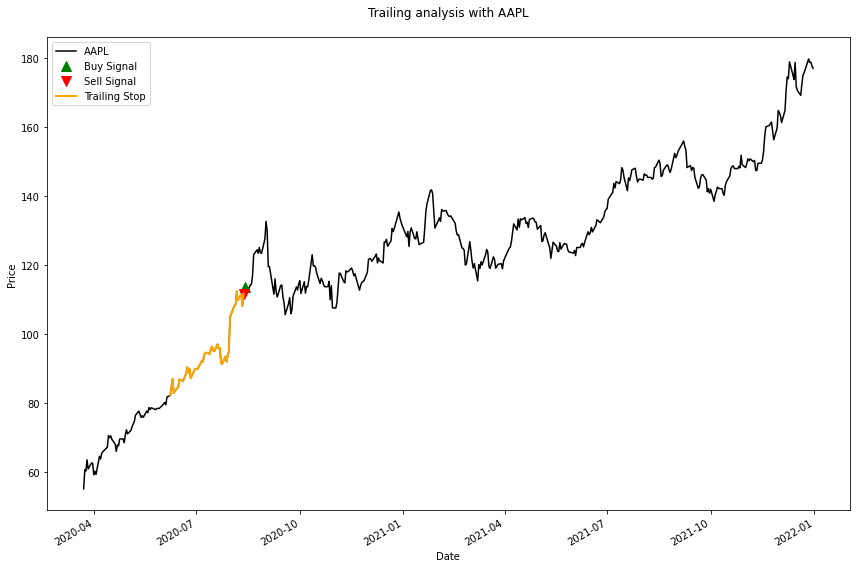

In [ ]:
# graph of trailing stop 

n = 450
stock = 'AAPL'

idx = df_position_trailing.index[-n:]

res, t_stops = signal_2_trailing(df_prices[stock])
buy_price = [df_prices[stock][i] if res['position_change'][i] == 1 else np.nan for i in range(res.shape[0])][-n:]
sell_price = [df_prices[stock][i] if res['position_change'][i] == -1 else np.nan for i in range(res.shape[0])][-n:]

t_stops = [np.nan if x==0 else df_prices[stock][n] for n,x in enumerate(t_stops)][-n:]

fig, ax = plt.subplots(figsize=(12,8))
ax.plot_date(idx, df_prices[stock][-n:],'-', label = stock, color = 'black')
ax.plot(idx, buy_price, marker = '^', color = 'green', markersize = 10, linewidth = 0, label = 'Buy Signal')
ax.plot(idx, sell_price, marker = 'v', color = 'r', markersize = 10, linewidth = 0, label = 'Sell Signal')
ax.plot(idx, t_stops, '-', color = 'orange', linewidth = 2, label = 'Trailing Stop')


fig.autofmt_xdate()

ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.title('Trailing analysis with {}\n'.format(stock))
plt.legend()
plt.tight_layout()
plt.show()

The graph shows that the trailing stops prevents an exit at around 80 USD while the stock still rises afterwards and a sell command is only triggered at the ~115 USD mark. Hence without a trailing stop enabled a price increase of ~40% would have been missed.